# Background

- Since I am struggling to get an adequate model for rotating the probe, I want to check that the measured value is constant when repeating the measurement at each step.

# Imports

In [73]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [74]:
import numpy as np
import pandas as pd
import pickle as pkl
from datetime import datetime
from datetime import timedelta
from pandas.api.types import is_numeric_dtype
from scipy.interpolate import interp1d
from scipy.spatial.transform import Rotation
import lmfit as lm
from copy import deepcopy
#from dateutil import parser
from plotly import graph_objects as go
from plotly.offline import plot
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline

# local imports
from plotting import config_plots, datetime_plt, get_label
from load_slow import *
from Zaber_Magnet_Convert import *
# hallprobecalib package
from hallprobecalib.hpcplots import scatter3d, scatter2d, histo, spherical_scatter3d
from mu2e.mu2eplots import mu2e_plot3d
# V vs. B, T (2021 results)
from V_vs_B_T import V_forward, inv_B_v2, invert_row, calc_B_column

# from pandas.api.types import is_numeric_dtype
# from dateutil import parser

config_plots()
# plt.rcParams.update({"text.usetex": True})

In [75]:
ddir = '/home/ckampa/Dropbox/LogFiles/temp_rotate_07-06-22/'

In [76]:
# 8-11-22 10:42, probe ##, rotating in magnet, fine scan
# PGC @ 20 deg C
# 1 deg steps -10 -- +6 angle 0 (theta)
# 2 deg steps full 360 deg, centered on 0 deg angle 1 (phi)
######
plotdir = '/home/ckampa/data/hallprobecalib_extras/plots/hall_probe_rotate/2022-07-07_12:04/'
scanfile = ddir+'2022-08-11 104249.txt'
slowfile = ddir+'2022-07-18 153459slow.txt'

# Load & Process Data

In [77]:
# temperature
df_temp = load_data(slowfile)

In [78]:
df_temp

Time  Magnet Current [A]  \
Datetime                                                        
2022-07-18 15:35:00  7/18/2022 3:35:00 PM          128.038503   
2022-07-18 15:35:36  7/18/2022 3:35:36 PM          128.038107   
2022-07-18 15:40:37  7/18/2022 3:40:37 PM          128.037993   
2022-07-18 15:45:37  7/18/2022 3:45:37 PM          128.038050   
2022-07-18 15:50:37  7/18/2022 3:50:37 PM          128.038050   
...                                   ...                 ...   
2022-08-19 08:30:44  8/19/2022 8:30:44 AM          128.037540   
2022-08-19 08:35:44  8/19/2022 8:35:44 AM          128.037540   
2022-08-19 08:40:44  8/19/2022 8:40:44 AM          128.037653   
2022-08-19 08:45:44  8/19/2022 8:45:44 AM          128.037540   
2022-08-19 08:50:44  8/19/2022 8:50:44 AM          128.037540   

                     Magnet Voltage [V]     Coil 1     Coil 2  LCW in Coil1  \
Datetime                                                                      
2022-07-18 15:35:00           14.520857  20.172779  19.498810      7.294656   
2022-07-18 15:35:36           14.517358  20.126730  19.449253      7.614744   
2022-07-18 15:40:37           14.518373  20.142616  19.518778      7.428334   
2022-07-18 15:45:37           14.518932  20.131069  19.502581      7.302032   
2022-07-18 15:50:37           14.519807  20.140829  19.496239      7.643779   
...                                 ...        ...        ...           ...   
2022-08-19 08:30:44           14.467185  18.033382  17.341083      6.655158   
2022-08-19 08:35:44           14.467728  18.050142  17.347694      6.523291   
2022-08-19 08:40:44           14.469237  18.053833  17.358664      6.585488   
2022-08-19 08:45:44           14.470498  18.044550  17.351385      7.342664   
2022-08-19 08:50:44           14.469810  18.011677  17.339159      8.084553   

                     LCW out Coil 1  LCW in Coil 2  LCW out Coil 2  \
Datetime                                                             
2022-07-18 15:35:00       10.641733      10.777012        9.891079   
2022-07-18 15:35:36       10.714738      10.928864       10.098615   
2022-07-18 15:40:37       10.656361      10.775543        9.964303   
2022-07-18 15:45:37       10.634292      10.769531        9.874829   
2022-07-18 15:50:37       10.999976      11.081547       10.143119   
...                             ...            ...             ...   
2022-08-19 08:30:44        8.479472       8.747259        8.724067   
2022-08-19 08:35:44        8.420097       8.753326        8.622375   
2022-08-19 08:40:44        8.558888       8.906497        8.712579   
2022-08-19 08:45:44        9.197866       9.446467        9.369908   
2022-08-19 08:50:44        9.662825       9.790860        9.897148   

                     Yoke (near pole)  ...  Return Magnet (NWC-R)  \
Datetime                               ...                          
2022-07-18 15:35:00         24.216312  ...              10.005183   
2022-07-18 15:35:36         24.206146  ...              10.090763   
2022-07-18 15:40:37         24.158566  ...               9.928845   
2022-07-18 15:45:37         24.110613  ...              10.065604   
2022-07-18 15:50:37         24.069481  ...              10.603743   
...                               ...  ...                    ...   
2022-08-19 08:30:44         16.433062  ...               8.877902   
2022-08-19 08:35:44         16.436317  ...               8.873909   
2022-08-19 08:40:44         16.443163  ...               9.295719   
2022-08-19 08:45:44         16.440182  ...               9.969002   
2022-08-19 08:50:44         16.443518  ...              10.111537   

                     Chiller Exhaust (NW)  Supply Magnet (NWC-S)  NaN (NWC-S)  \
Datetime                                                                        
2022-07-18 15:35:00             31.155783               7.957991    18.461817   
2022-07-18 15:35:36             30.256037               8.250588    18.460640   
2022-07-18 15:40:37           

<AxesSubplot:xlabel='Datetime'>

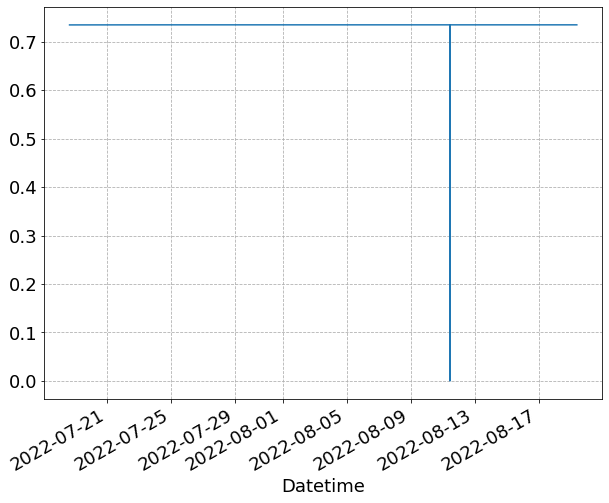

In [79]:
df_temp['NMR [T]'].plot()

In [80]:
len(df_temp)

9137

In [81]:
df_temp = df_temp.query('`NMR [T]` > 0.7').copy()

In [82]:
len(df_temp)

9136

<AxesSubplot:xlabel='Datetime'>

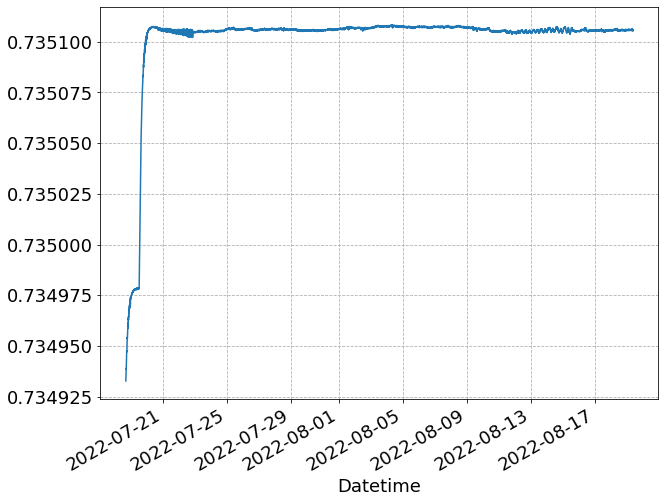

In [83]:
df_temp['NMR [T]'].plot()

In [84]:
df_temp['NMR [T]']

Datetime
2022-07-18 15:35:00    0.734933
2022-07-18 15:35:36    0.734933
2022-07-18 15:40:37    0.734934
2022-07-18 15:45:37    0.734935
2022-07-18 15:50:37    0.734936
                         ...   
2022-08-19 08:30:44    0.735106
2022-08-19 08:35:44    0.735105
2022-08-19 08:40:44    0.735105
2022-08-19 08:45:44    0.735106
2022-08-19 08:50:44    0.735105
Name: NMR [T], Length: 9136, dtype: float64

In [85]:
df = load_data(scanfile).iloc[1:]

In [86]:
df

Time  Magnet Current [A]  \
Datetime                                                         
2022-08-11 10:43:23  8/11/2022 10:43:23 AM          128.037540   
2022-08-11 10:43:30  8/11/2022 10:43:30 AM          128.037483   
2022-08-11 10:43:37  8/11/2022 10:43:37 AM          128.037427   
2022-08-11 10:43:45  8/11/2022 10:43:45 AM          128.037483   
2022-08-11 10:43:52  8/11/2022 10:43:52 AM          128.037540   
...                                    ...                 ...   
2022-08-15 13:30:44   8/15/2022 1:30:44 PM          128.037597   
2022-08-15 13:30:51   8/15/2022 1:30:51 PM          128.037597   
2022-08-15 13:30:58   8/15/2022 1:30:58 PM          128.037540   
2022-08-15 13:31:06   8/15/2022 1:31:06 PM          128.037710   
2022-08-15 13:31:13   8/15/2022 1:31:13 PM          128.037710   

                     Magnet Voltage [V]  NMR [T]  NMR [FFT]  \
Datetime                                                      
2022-08-11 10:43:23           14.469108      0.0        0.0   
2022-08-11 10:43:30           14.469455      0.0        0.0   
2022-08-11 10:43:37           14.469785      0.0        0.0   
2022-08-11 10:43:45           14.470080      0.0        0.0   
2022-08-11 10:43:52           14.470307      0.0        0.0   
...                                 ...      ...        ...   
2022-08-15 13:30:44           14.468947      0.0        0.0   
2022-08-15 13:30:51           14.468798      0.0        0.0   
2022-08-15 13:30:58           14.468612      0.0        0.0   
2022-08-15 13:31:06           14.468363      0.0        0.0   
2022-08-15 13:31:13           14.468130      0.0        0.0   

                     2F0000000D5EC73A_Raw_X  2F0000000D5EC73A_Raw_Y  \
Datetime                                                              
2022-08-11 10:43:23                -65060.0               -283449.0   
2022-08-11 10:43:30                -65132.0               -283469.0   
2022-08-11 10:43:37                -65110.0               -283524.0   
2022-08-11 10:43:45                -65096.0               -283496.0   
2022-08-11 10:43:52                -65115.0               -283524.0   
...                                     ...                     ...   
2022-08-15 13:30:44                141435.0                228547.0   
2022-08-15 13:30:51                141483.0                228400.0   
2022-08-15 13:30:58                141428.0                228444.0   
2022-08-15 13:31:06                141492.0                228495.0   
2022-08-15 13:31:13                141495.0                228546.0   

                     2F0000000D5EC73A_Raw_Z  2F0000000D5EC73A_Raw_T  \
Datetime                                                              
2022-08-11 10:43:23              -2016403.0                 19344.0   
2022-08-11 10:43:30              -2016338.0                 19348.0   
2022-08-11 10:43:37              -2016323.0                 19348.0   
2022-08-11 10:43:45              -2016396.0                 19347.0   
2022-08-11 10:43:52              -2016517.0                 19348.0   
...                                     ...                     ...   
2022-08-15 13:30:44              -2031200.0                 19314.0   
2022-08-15 13:30:51              -2031345.0                 19316.0   
2022-08-15 13:30:58              -2031231.0                 19312.0   
2022-08-15 13:31:06              -2031226.0                 19314.0   
2022-08-15 13:31:13              -2031266.0                 19309.0   

                     2F0000000D5EC73A_Cal_X  ...  2F0000000D5EC73A_Cal_T  \
Datetime                                     ...                           
2022-08-11 10:43:23                0.726495  ...                  19.344   
2022-08-11 10:43:30                0.726473  ...                  19.348   
2022-08-11 10:43:37                0.726468  ...                  19.348   
2022-08-11 10:43:45                0.726494  ...                  19.347   
2022-08-11 10:43:52                0.726537  ...       

In [89]:
len(df.SmarAct_Pattern_Angle_1.unique()), len(df.SmarAct_Pattern_Angle_2.unique())

(17, 181)

In [90]:
len(df.SmarAct_Pattern_Angle_1.unique()) * len(df.SmarAct_Pattern_Angle_2.unique())

3077

In [91]:
len(df) / (len(df.SmarAct_Pattern_Angle_1.unique()) * len(df.SmarAct_Pattern_Angle_2.unique()))

15.0

<AxesSubplot:xlabel='Datetime'>

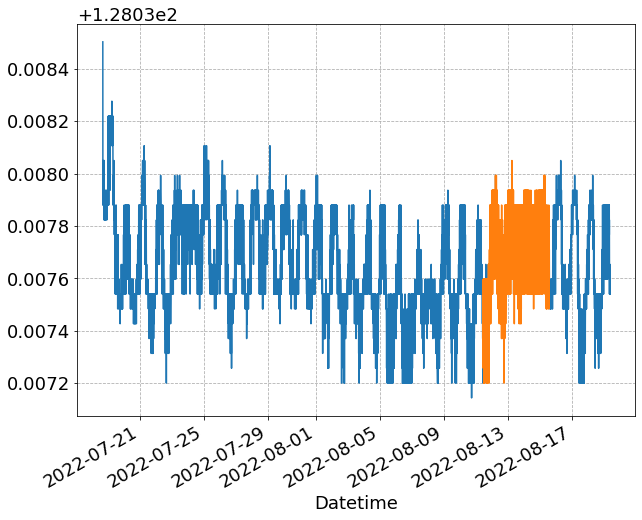

In [92]:
df_temp['Magnet Current [A]'].plot()
df['Magnet Current [A]'].plot()

In [93]:
df.columns

Index(['Time', 'Magnet Current [A]', 'Magnet Voltage [V]', 'NMR [T]',
       'NMR [FFT]', '2F0000000D5EC73A_Raw_X', '2F0000000D5EC73A_Raw_Y',
       '2F0000000D5EC73A_Raw_Z', '2F0000000D5EC73A_Raw_T',
       '2F0000000D5EC73A_Cal_X', '2F0000000D5EC73A_Cal_Y',
       '2F0000000D5EC73A_Cal_Z', '2F0000000D5EC73A_Cal_T',
       'SmarAct_Pattern_Angle_1', 'SmarAct_Pattern_Angle_2',
       'SmarAct_Meas_Angle_1', 'SmarAct_Meas_Rotation_Angle_1',
       'SmarAct_Meas_Angle_2', 'SmarAct_Meas_Rotation_Angle_2',
       'seconds_delta', 'hours_delta', 'days_delta'],
      dtype='object')

In [94]:
def get_probe_IDs(df):
    probes = [c[:-6] for c in df.columns if "Raw_X" in c]
    return sorted(probes)

In [95]:
probes = get_probe_IDs(df)
probe = probes[0]

In [96]:
probes, probe

(['2F0000000D5EC73A'], '2F0000000D5EC73A')

In [97]:
# Hall probe calculations
for p in probes:
    for t in ['Raw', 'Cal']:
        df[f'{p}_{t}_Bmag'] = (df[f'{p}_{t}_X']**2 + df[f'{p}_{t}_Y']**2 + df[f'{p}_{t}_Z']**2)**(1/2)
        df[f'{p}_{t}_Theta'] = np.arccos(df[f'{p}_{t}_Z']/df[f'{p}_{t}_Bmag'])
        df[f'{p}_{t}_Phi'] = np.arctan2(df[f'{p}_{t}_Y'],df[f'{p}_{t}_X'])
# again using theta redefining Cal components
for p in probes:
    for t in ['Cal']:
        df[f'{p}_{t}_Theta2'] = np.arccos(df[f'{p}_{t}_X']/df[f'{p}_{t}_Bmag'])
        df[f'{p}_{t}_Phi2'] = np.arctan2(df[f'{p}_{t}_Z'],df[f'{p}_{t}_Y'])

In [98]:
df['Magnet Resistance [Ohm]'] = df['Magnet Voltage [V]'] / df['Magnet Current [A]']
df['Coil Resistance [Ohm]'] = 2*df['Magnet Resistance [Ohm]']
df['Magnet Power [W]'] = df['Magnet Voltage [V]'] * df['Magnet Current [A]']

In [99]:
df[['Magnet Power [W]', 'Coil Resistance [Ohm]']]

Magnet Power [W]  Coil Resistance [Ohm]
Datetime                                                    
2022-08-11 10:43:23       1852.589037               0.226014
2022-08-11 10:43:30       1852.632603               0.226019
2022-08-11 10:43:37       1852.674036               0.226024
2022-08-11 10:43:45       1852.712627               0.226029
2022-08-11 10:43:52       1852.742469               0.226032
...                               ...                    ...
2022-08-15 13:30:44       1852.569158               0.226011
2022-08-15 13:30:51       1852.550165               0.226009
2022-08-15 13:30:58       1852.525445               0.226006
2022-08-15 13:31:06       1852.496109               0.226002
2022-08-15 13:31:13       1852.466233               0.225998

[46155 rows x 2 columns]

<AxesSubplot:xlabel='Datetime'>

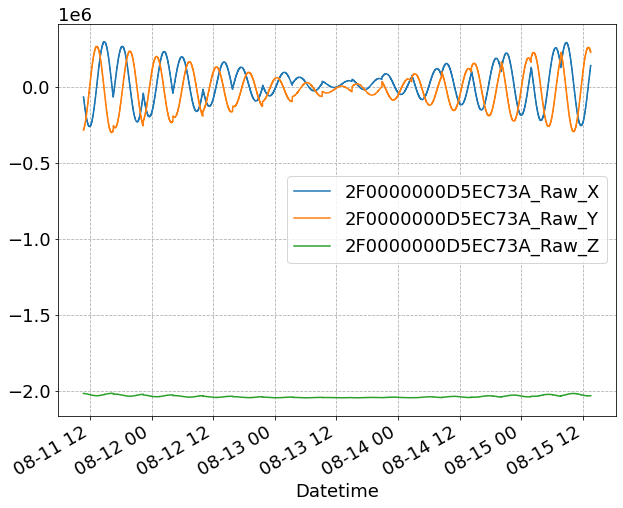

In [100]:
df[[f'{probe}_Raw_{i}' for i in ['X', 'Y', 'Z']]].plot()

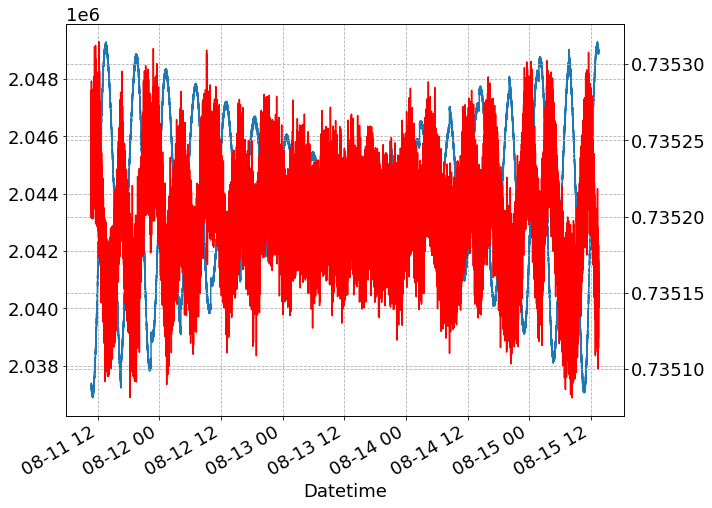

In [101]:
ax = df[f'{probe}_Raw_Bmag'].plot()
ax2 = ax.twinx()
ax2.plot(df.index, df[f'{probe}_Cal_Bmag'], 'r')

<AxesSubplot:xlabel='Datetime'>

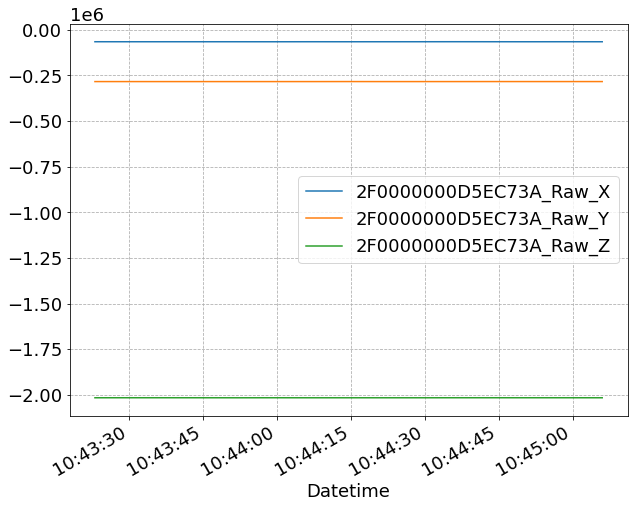

In [120]:
df[[f'{probe}_Raw_{i}' for i in ['X', 'Y', 'Z']]].iloc[:15].plot()

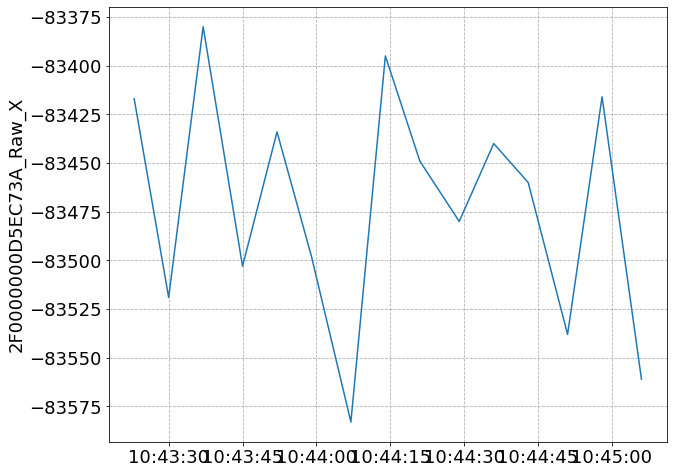

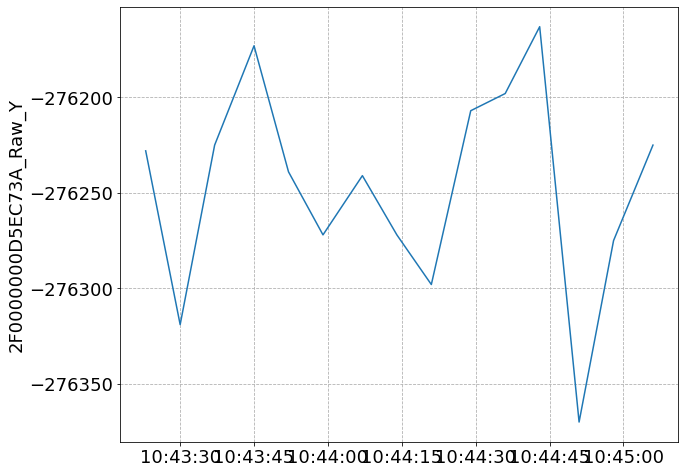

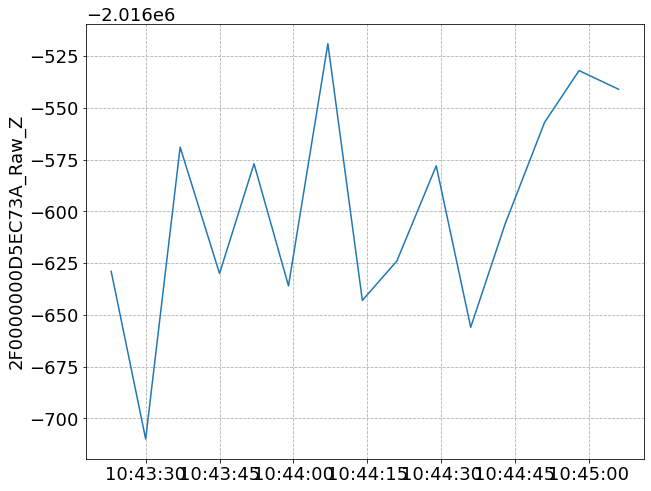

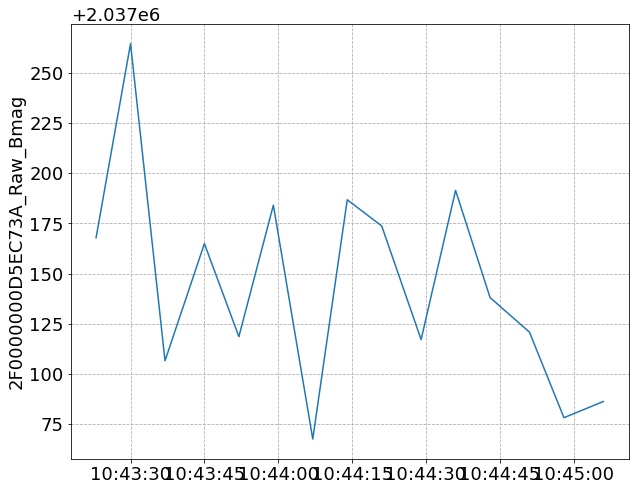

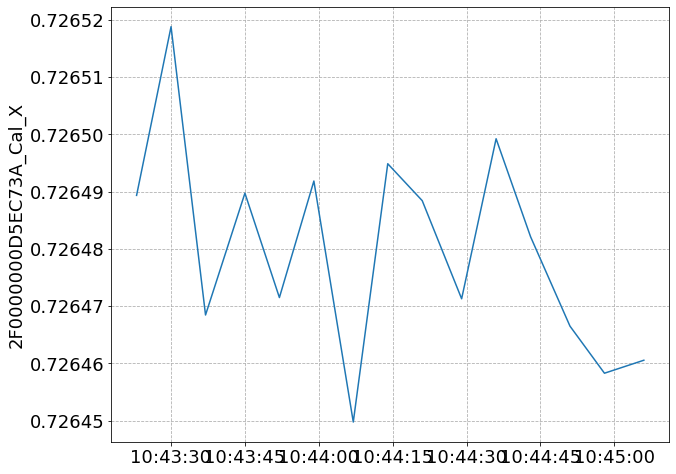

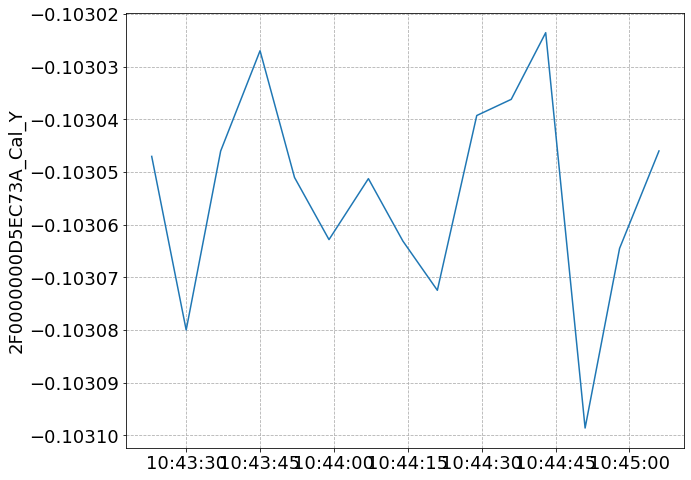

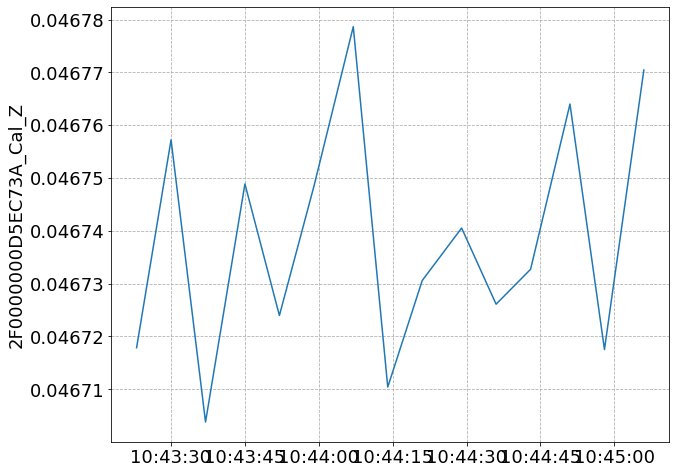

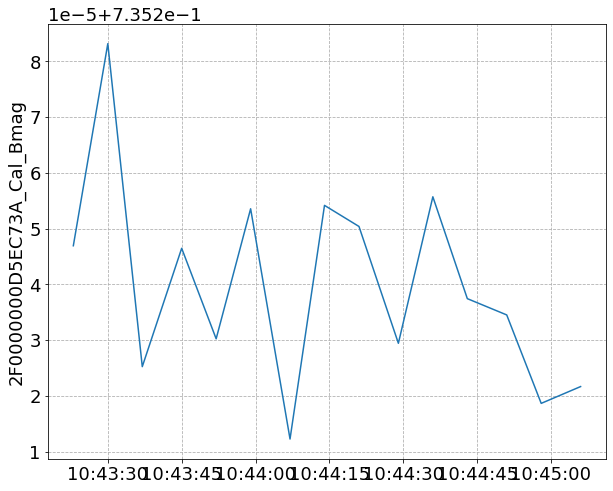

In [103]:
N = 2
for cal in ['Raw', 'Cal']:
    for i in ['X', 'Y', 'Z', 'Bmag']:
        fig, ax = plt.subplots()
        ax.plot(df.iloc[:15].index, df[f'{probe}_{cal}_{i}'].iloc[N*15:(N+1)*15])
        ax.set_ylabel(f'{probe}_{cal}_{i}')

# Simple Analysis

- Look visually (and numerically) for changes in values during a scan.

In [104]:
probe

'2F0000000D5EC73A'

In [105]:
for c in df.columns:
    if probe in c:
        print(c, end=' ')

2F0000000D5EC73A_Raw_X 2F0000000D5EC73A_Raw_Y 2F0000000D5EC73A_Raw_Z 2F0000000D5EC73A_Raw_T 2F0000000D5EC73A_Cal_X 2F0000000D5EC73A_Cal_Y 2F0000000D5EC73A_Cal_Z 2F0000000D5EC73A_Cal_T 2F0000000D5EC73A_Raw_Bmag 2F0000000D5EC73A_Raw_Theta 2F0000000D5EC73A_Raw_Phi 2F0000000D5EC73A_Cal_Bmag 2F0000000D5EC73A_Cal_Theta 2F0000000D5EC73A_Cal_Phi 2F0000000D5EC73A_Cal_Theta2 2F0000000D5EC73A_Cal_Phi2 

In [153]:
def analyze_pattern_point(df, Pattern_Angle_1, Pattern_Angle_2):
    df_ = df[(np.isclose(df.SmarAct_Pattern_Angle_1, Pattern_Angle_1)) & (np.isclose(df.SmarAct_Pattern_Angle_2, Pattern_Angle_2))]
    return df_

def get_label(ys):
    # note: must be a pandas series.
    label_temp = r'$\mu = {0:.3E}$'+ '\n' + 'std' + r'$= {1:.3E}$' + '\n' +  'range' + r'$= {2:.3E}$' + '\n' + 'Integral: {3}'
    label = label_temp.format(ys.mean(), ys.std(), np.ptp(ys), len(ys))
    return label

def plot_components_pattern_point(df, Pattern_Angle_1, Pattern_Angle_2, components=['Raw_X', 'Raw_Y', 'Raw_Z', 'Raw_Bmag', 'Cal_T'], probe=probe, Delta=True, Relative=True):
    df_ = analyze_pattern_point(df, Pattern_Angle_1, Pattern_Angle_2)
    for comp in components:
        col = f'{probe}_{comp}'
        fig, ax = plt.subplots()
        rel=''
        del_=''
        if not Delta:
            ys = df_[col]
        else:
            del_='Delta '
            y0 = df_[col].values[0]
            if Relative:
                rel='Relative '
                ys = (df_[col] - y0) / df_[col]
            else:
                ys = (df_[col] - y0)
        
        ax.scatter(df_.index, ys, s=10, c='blue', label=get_label(ys))
        
        ax.set_xlabel('Datetime')
        ax.set_ylabel(f'{rel}{del_}{col}')
        ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
        ax.set_title(f'SmarAct Pattern: Angle1={Pattern_Angle_1:0.1f} deg, Angle2={Pattern_Angle_2:0.1f} deg\n')
        #fig.tight_layout()
    return df_

def summary_stat_pattern_points(df, components=['Raw_X', 'Raw_Y', 'Raw_Z', 'Raw_Bmag', 'Cal_T'], probe=probe, Delta=True, Relative=True):
    data = {'SmarAct_Pattern_Angle_1':[], 'SmarAct_Pattern_Angle_2':[], 'Integral':[]}
    for comp in components:
        for postfix in ['mean', 'std', 'range']:
            data[f'{probe}_{comp}_{postfix}'] = []
    for SA1 in df.SmarAct_Pattern_Angle_1.unique():
        for SA2 in df.SmarAct_Pattern_Angle_2.unique():
            data['SmarAct_Pattern_Angle_1'].append(SA1)
            data['SmarAct_Pattern_Angle_2'].append(SA2)
            df_ = analyze_pattern_point(df, SA1, SA2)
            data['Integral'].append(len(df_))
            for comp in components:
                col = f'{probe}_{comp}'
                ys = df_[col]
                if Delta:
                    y0 = ys[0]
                    if Relative:
                        ys = (ys - ys[0])/ys
                    else:
                        ys = ys - ys[0]
                data[f'{col}_mean'].append(ys.mean())
                data[f'{col}_std'].append(ys.std())
                data[f'{col}_range'].append(np.ptp(ys))
    df_stat = pd.DataFrame(data)
    return df_stat

In [154]:
%time df_stat = summary_stat_pattern_points(df)

CPU times: user 5.92 s, sys: 0 ns, total: 5.92 s
Wall time: 5.92 s


In [155]:
df_stat = summary_stat_pattern_points(df)

In [160]:
df_stat_nonrel = summary_stat_pattern_points(df, Relative=False)

In [168]:
cal_cols= ['Cal_X', 'Cal_Y', 'Cal_Z', 'Cal_Bmag', 'Cal_T']
df_stat_cal = summary_stat_pattern_points(df, components=cal_cols)
df_stat_cal_nonrel = nonrel = summary_stat_pattern_points(df, components=cal_cols, Relative=False)

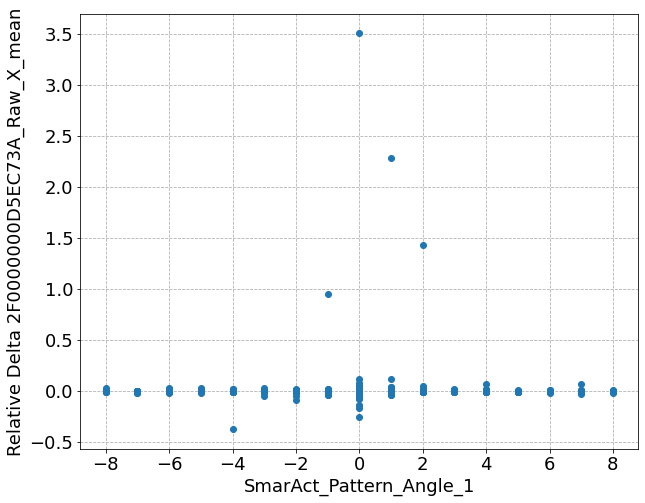

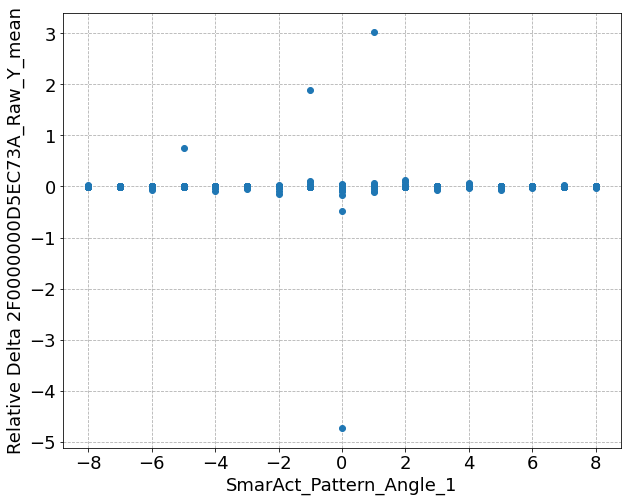

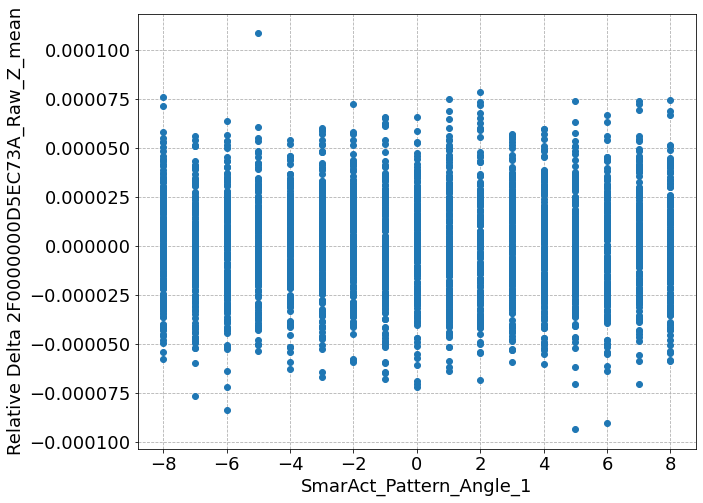

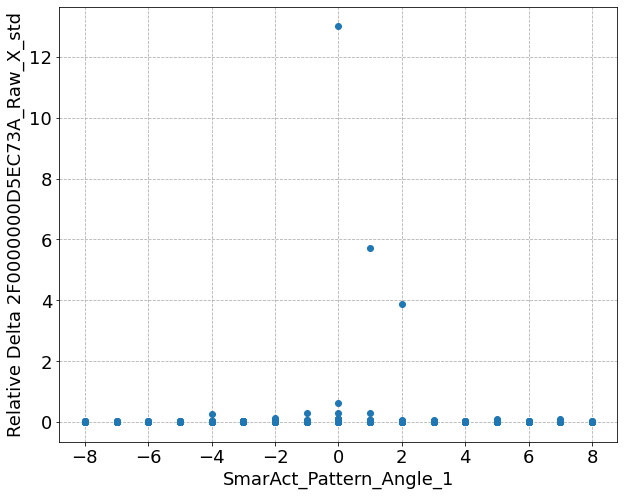

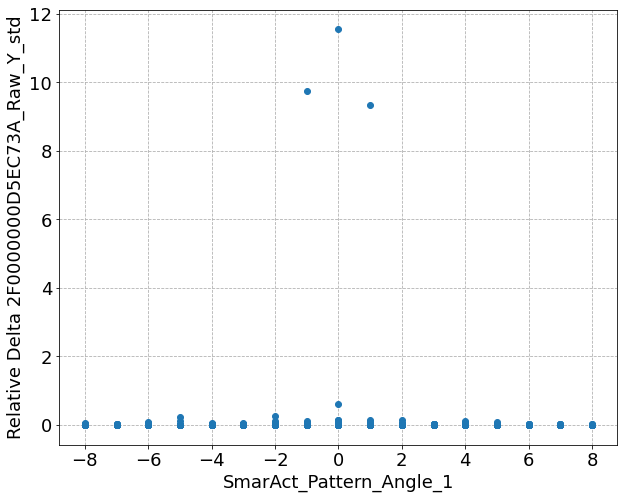

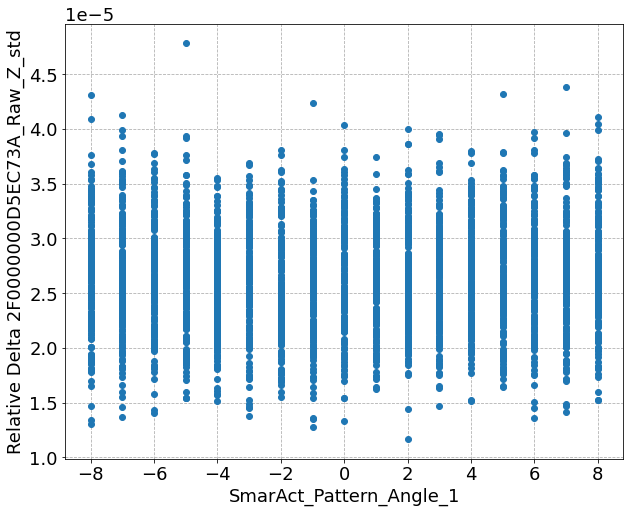

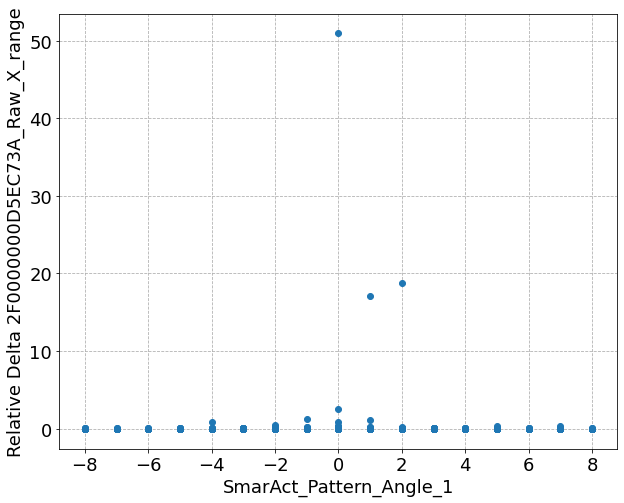

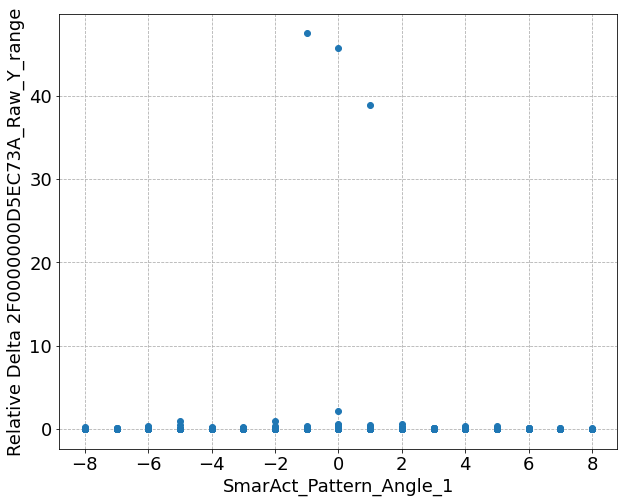

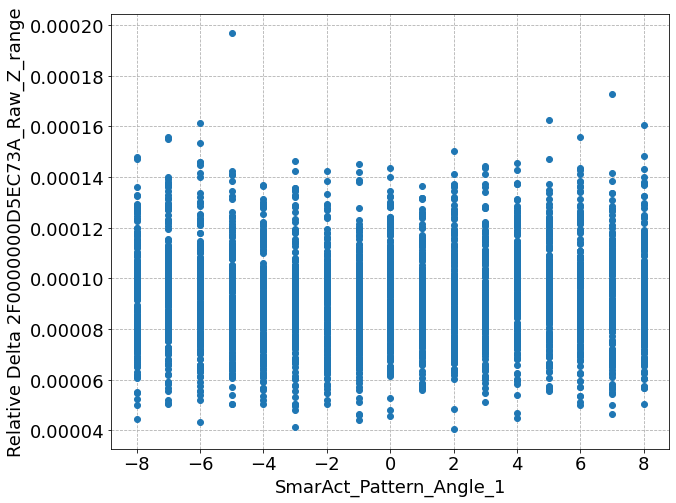

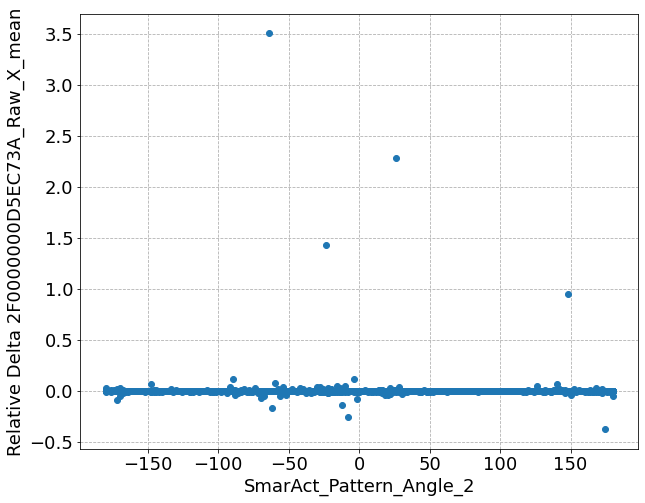

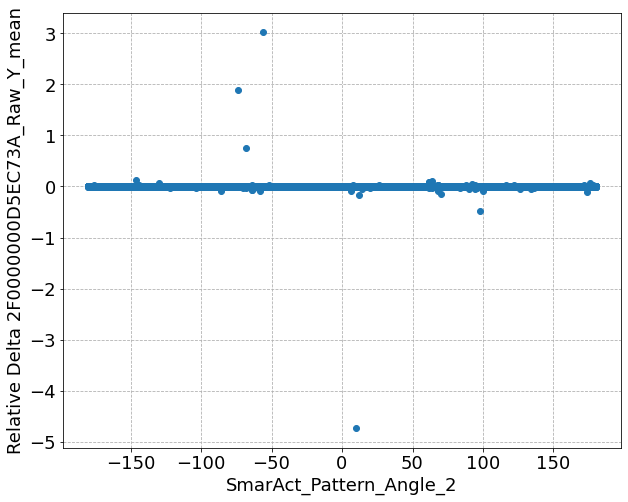

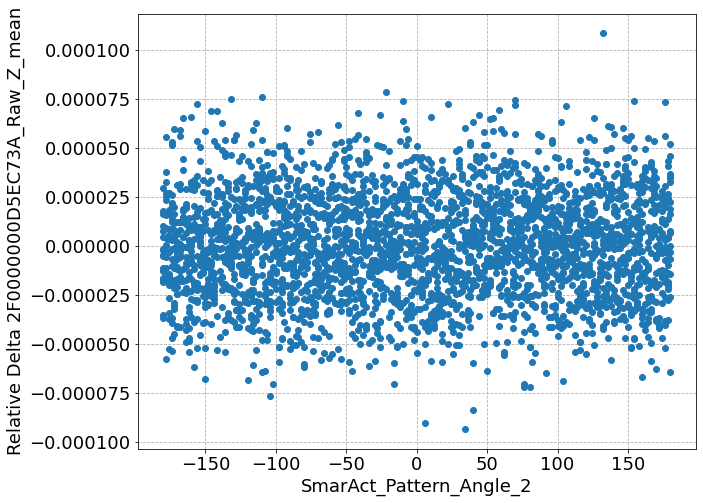

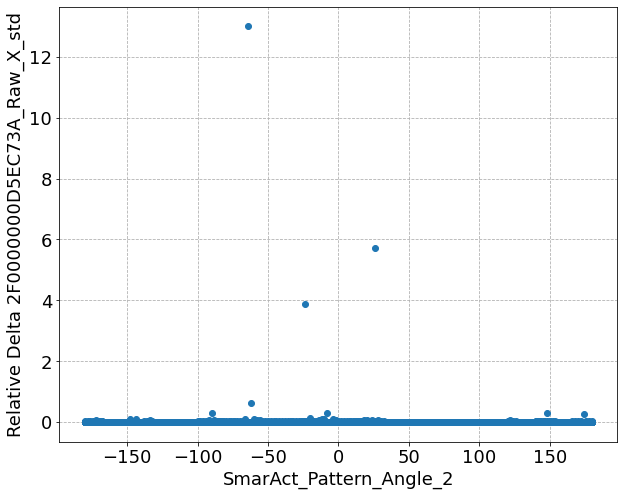

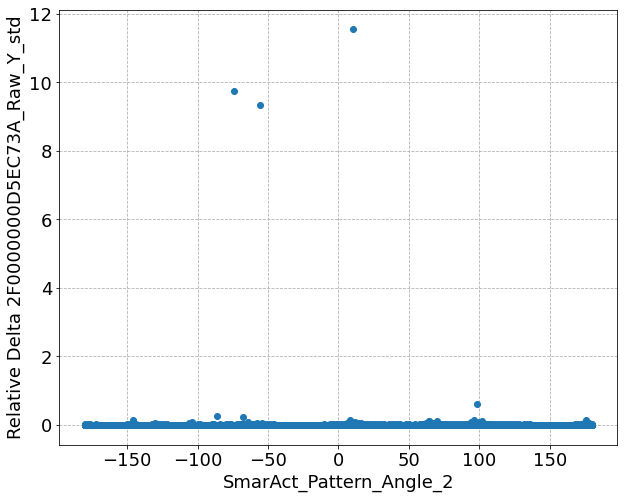

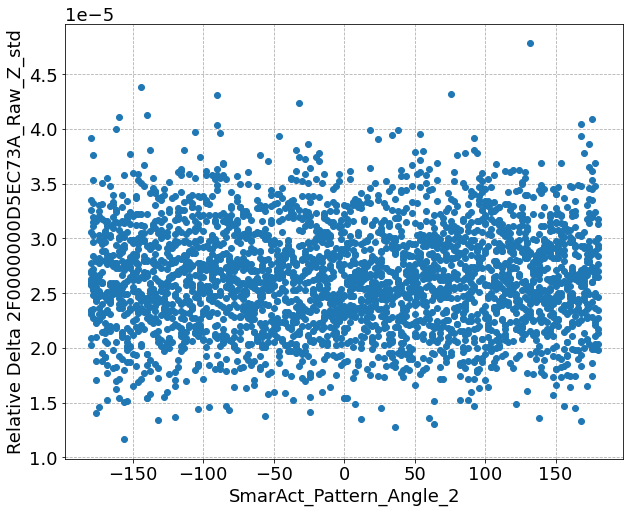

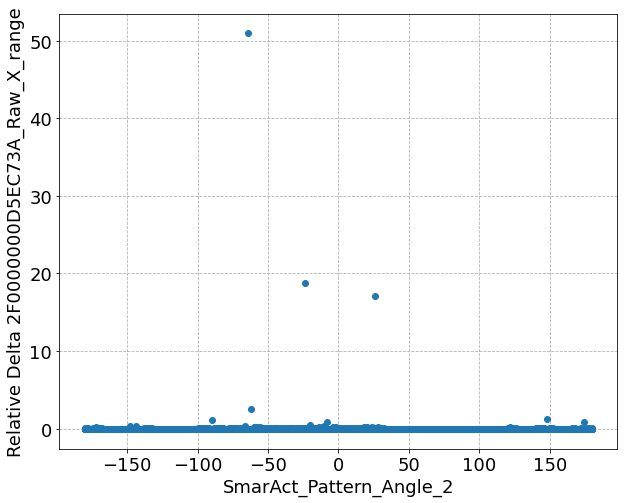

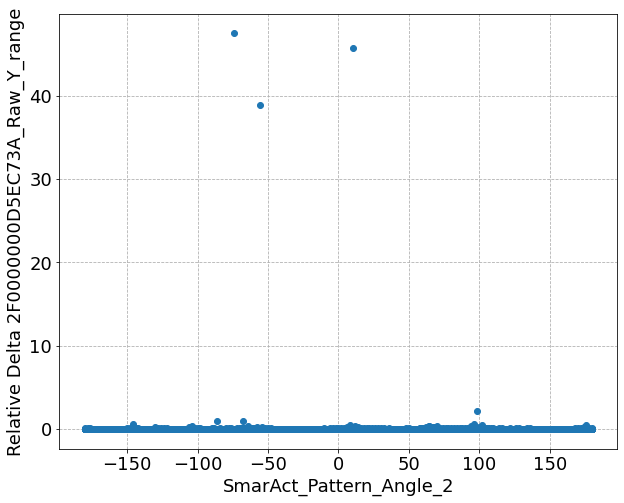

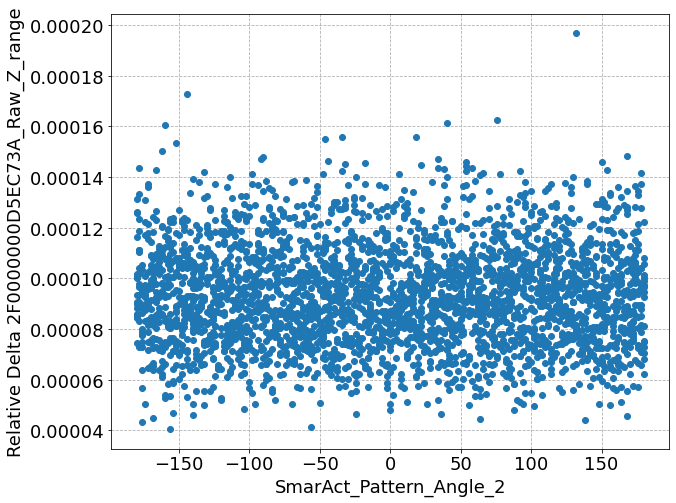

In [159]:
for A in ['1', '2']:
    for postfix in ['mean', 'std', 'range']:
        for i in ['X', 'Y', 'Z']:
            fig, ax = plt.subplots()
            ax.scatter(df_stat[f'SmarAct_Pattern_Angle_{A}'], df_stat[f'{probe}_Raw_{i}_{postfix}'])

            ax.set_xlabel(f'SmarAct_Pattern_Angle_{A}')
            ax.set_ylabel(f'Relative Delta {probe}_Raw_{i}_{postfix}')

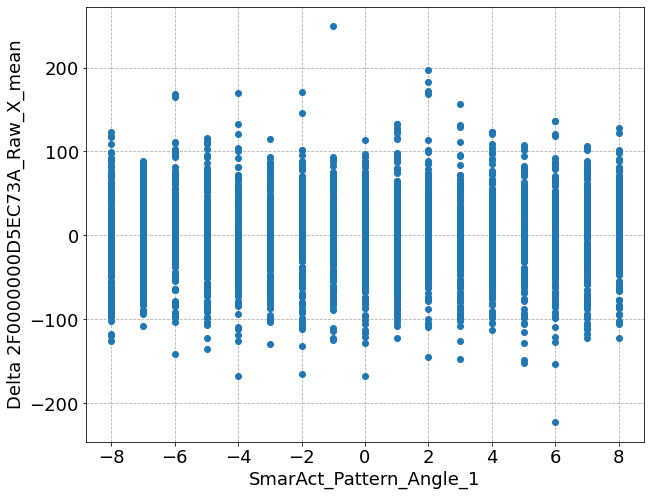

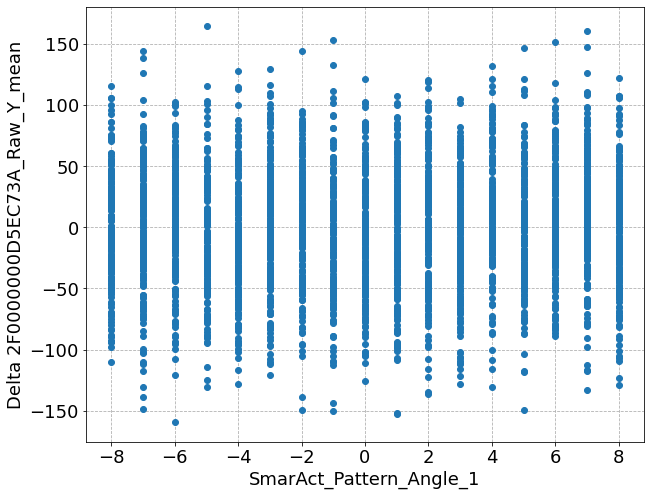

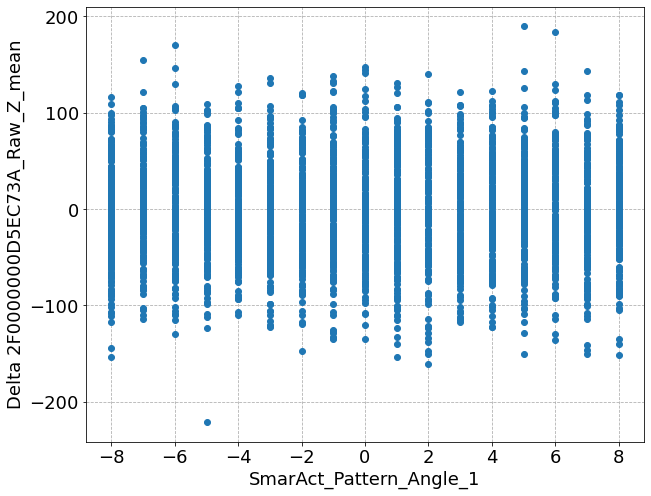

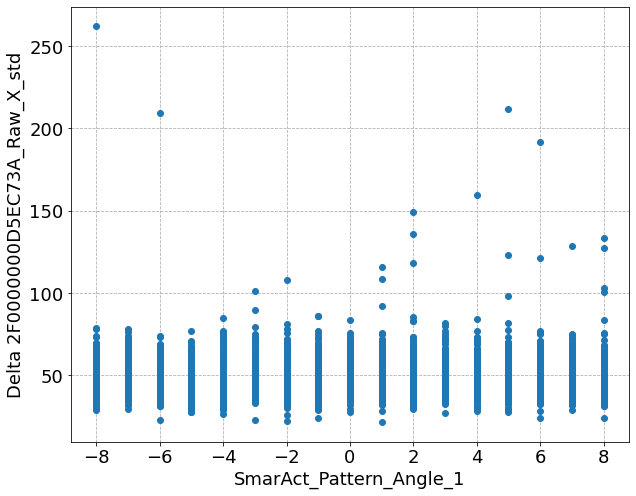

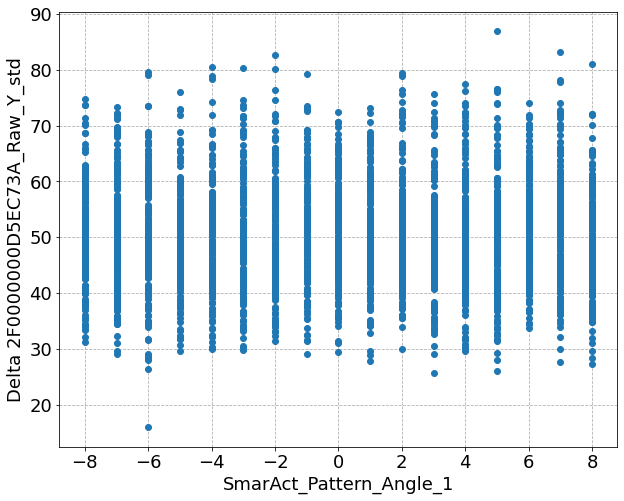

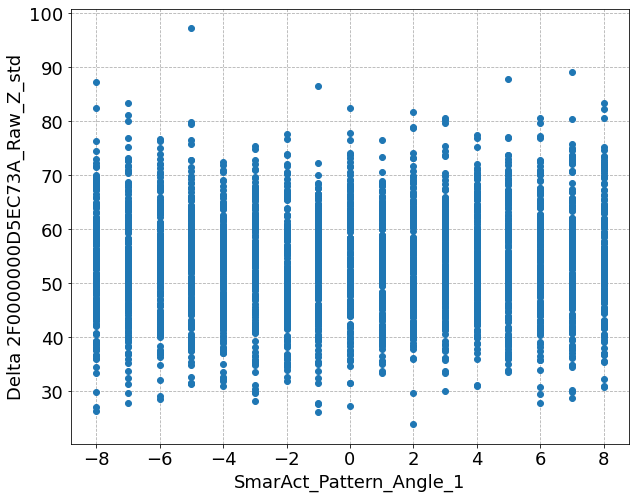

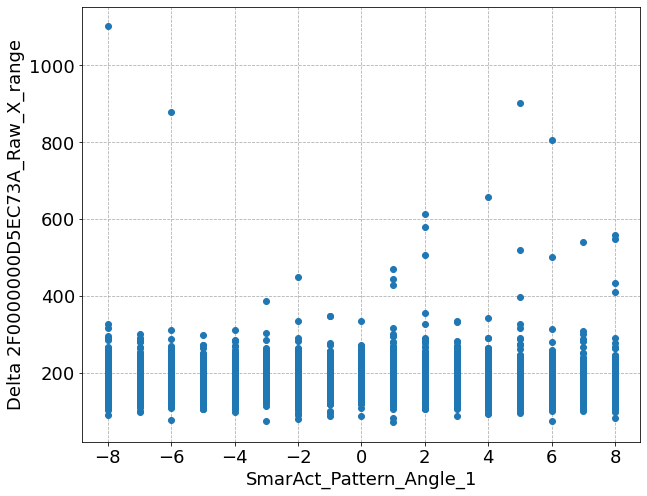

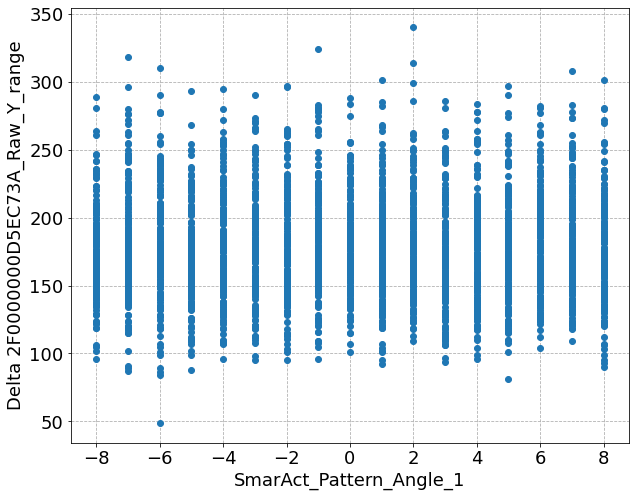

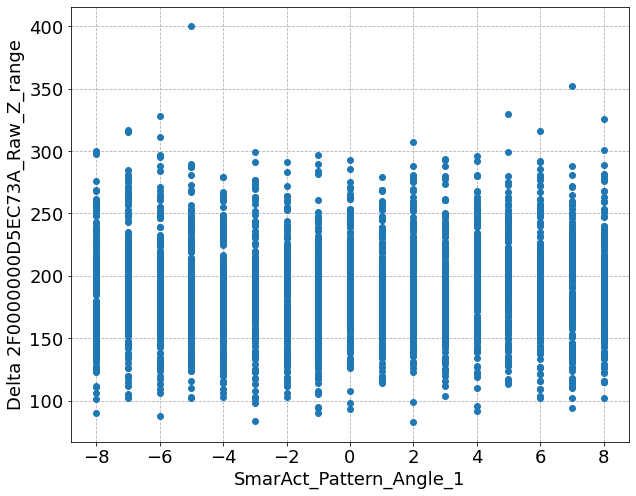

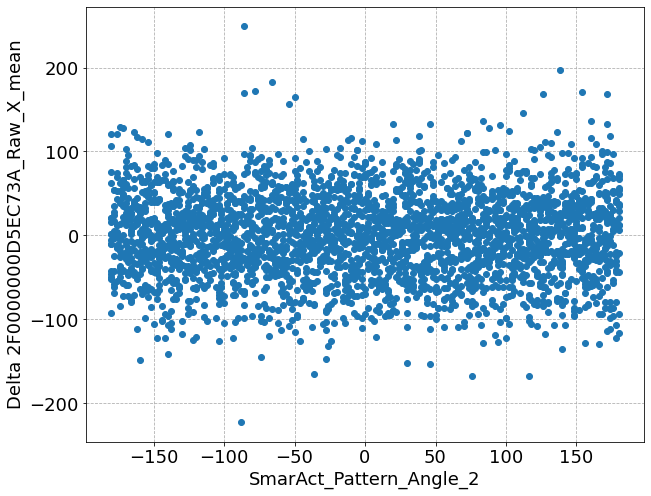

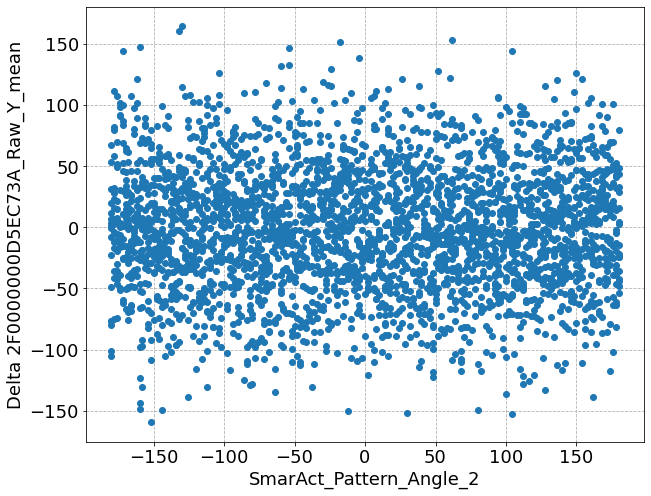

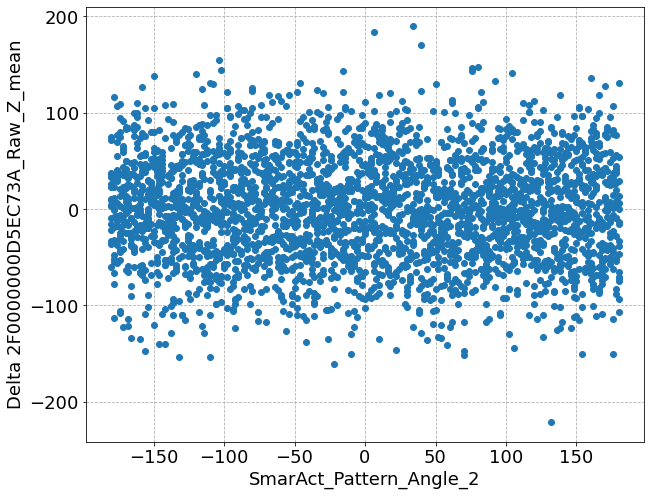

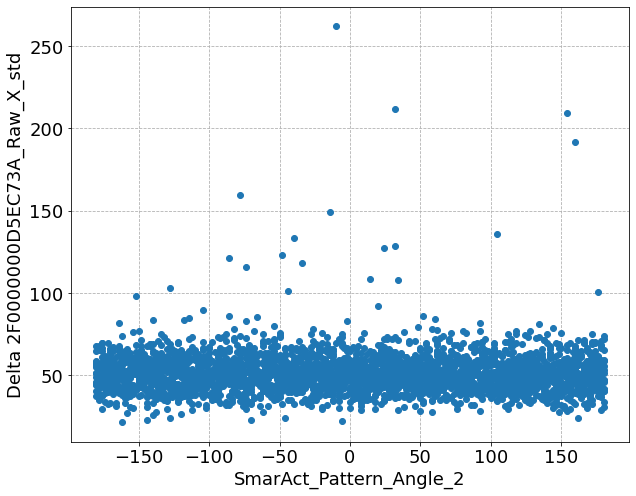

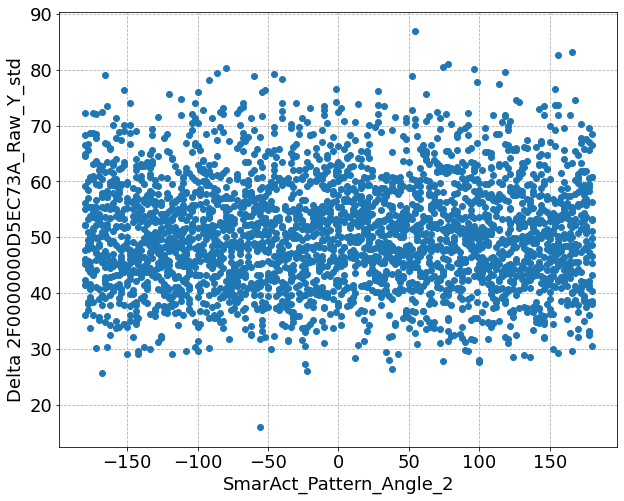

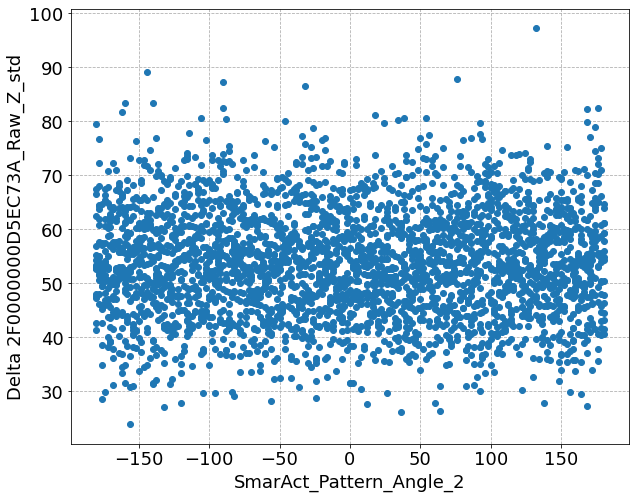

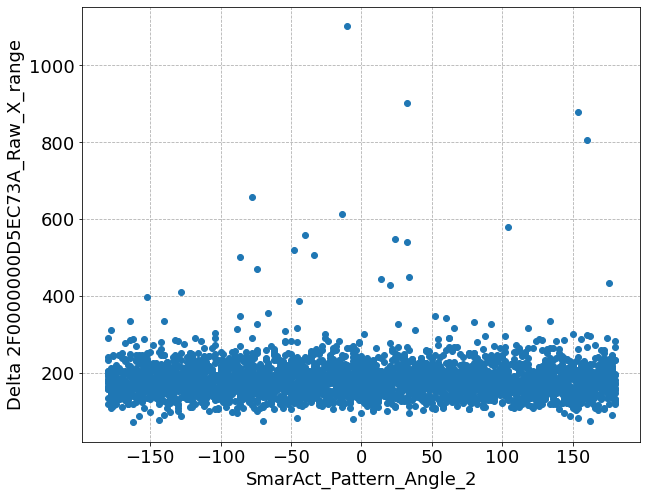

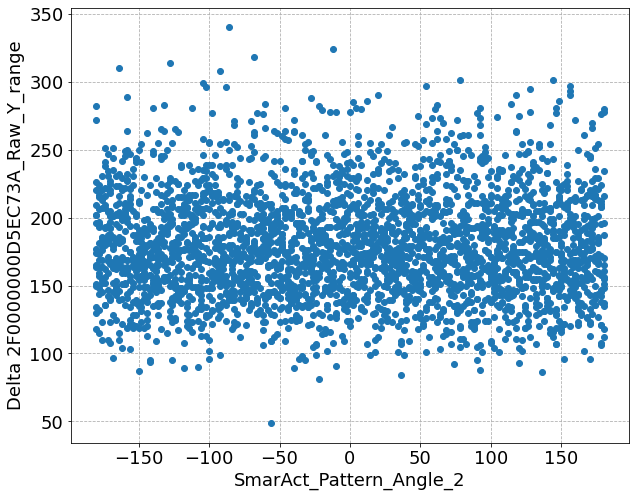

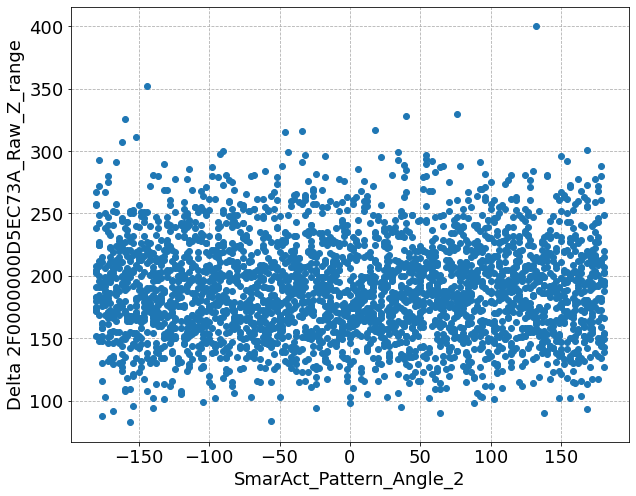

In [161]:
for A in ['1', '2']:
    for postfix in ['mean', 'std', 'range']:
        for i in ['X', 'Y', 'Z']:
            fig, ax = plt.subplots()
            ax.scatter(df_stat_nonrel[f'SmarAct_Pattern_Angle_{A}'], df_stat_nonrel[f'{probe}_Raw_{i}_{postfix}'])

            ax.set_xlabel(f'SmarAct_Pattern_Angle_{A}')
            ax.set_ylabel(f'Delta {probe}_Raw_{i}_{postfix}')

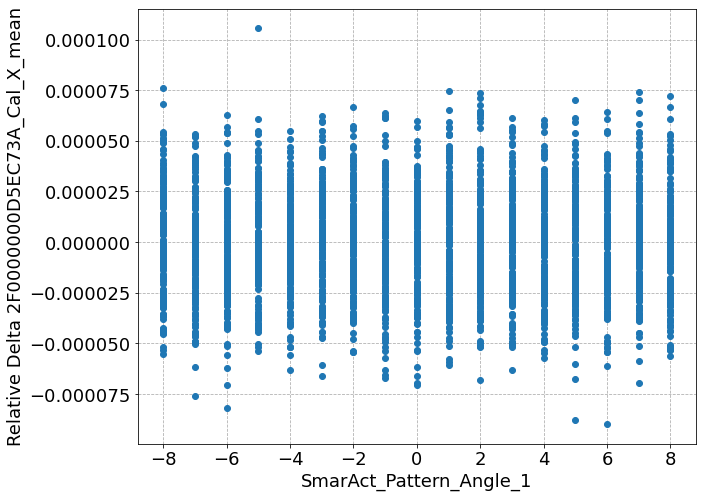

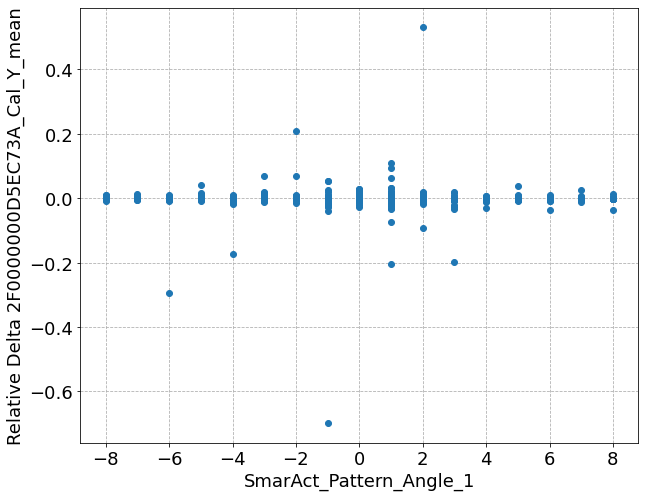

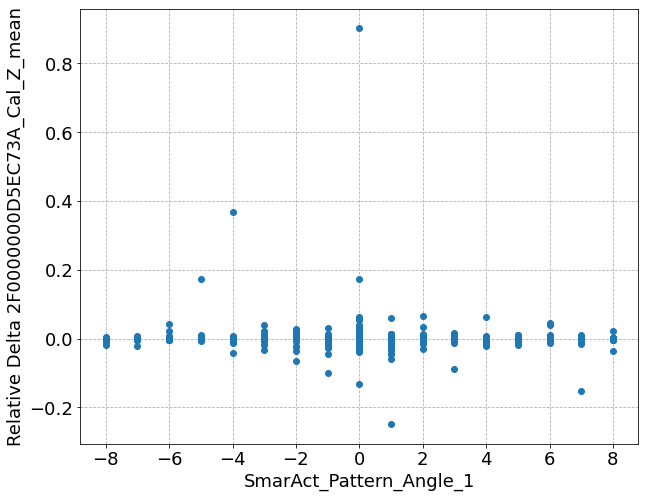

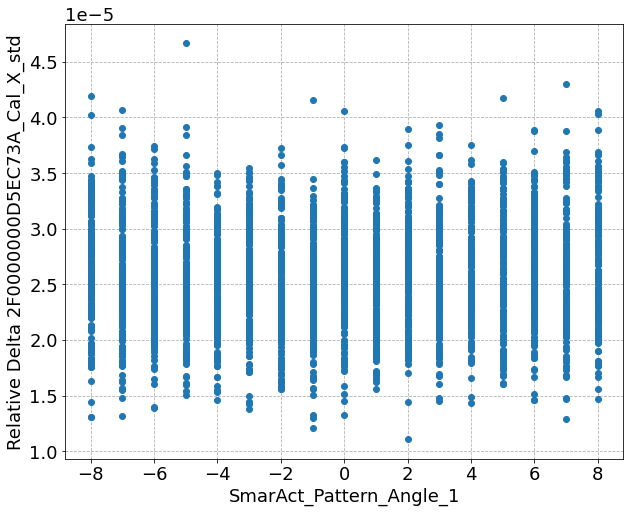

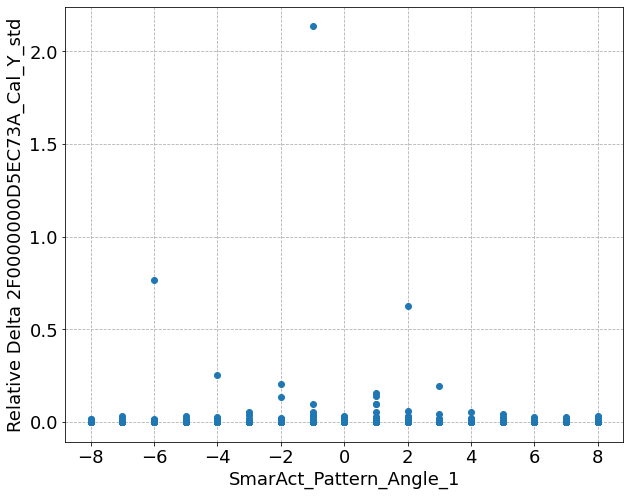

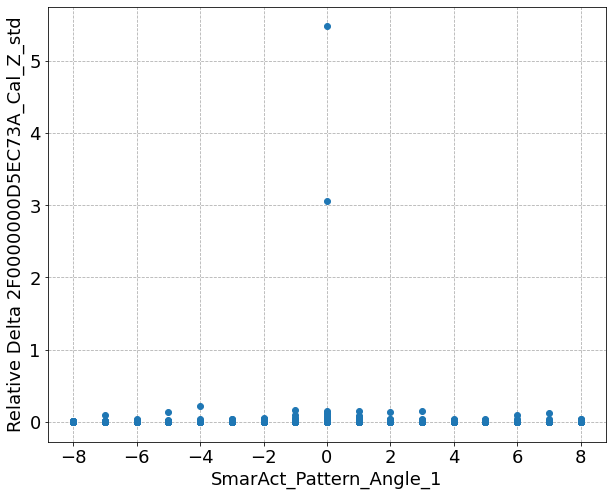

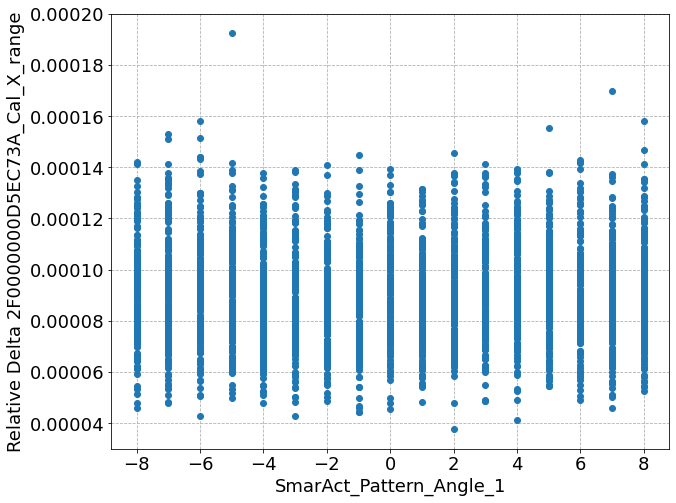

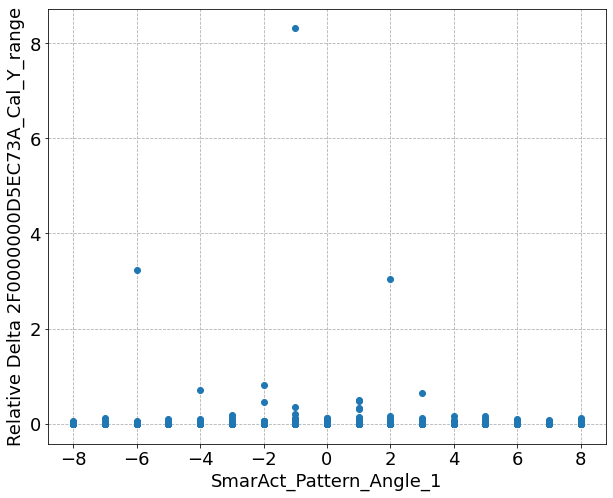

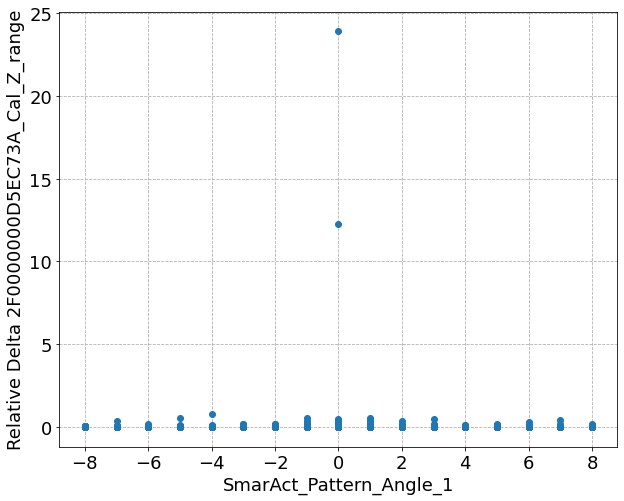

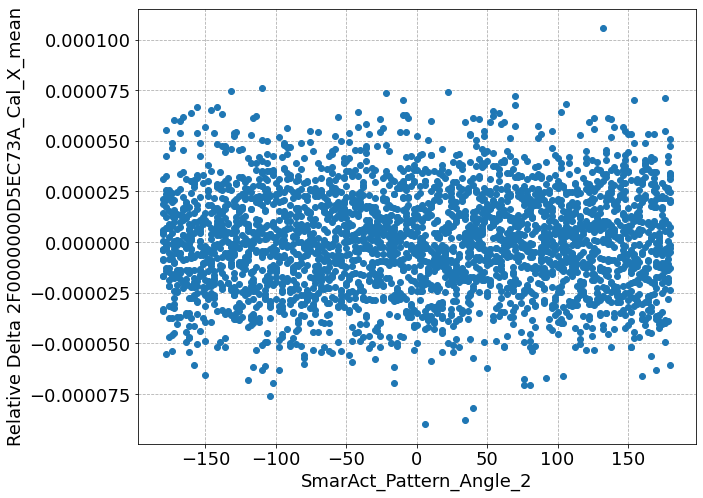

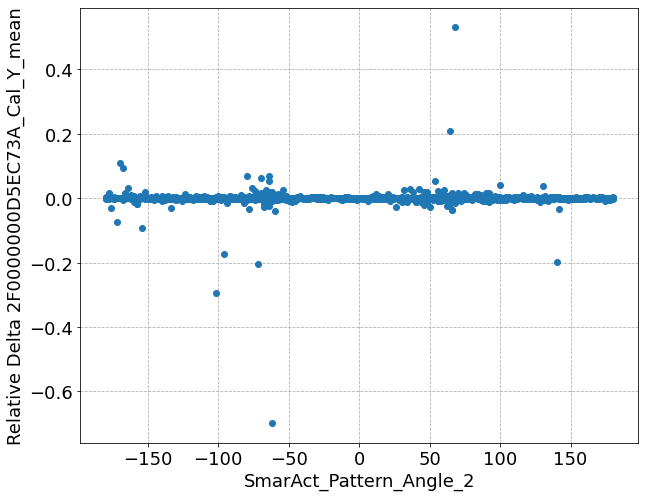

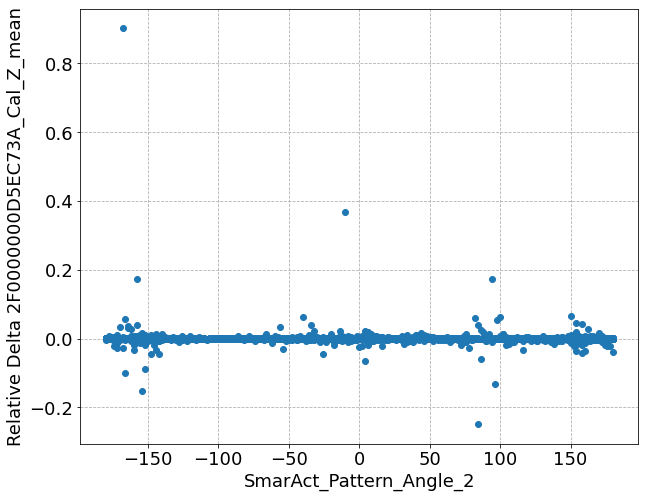

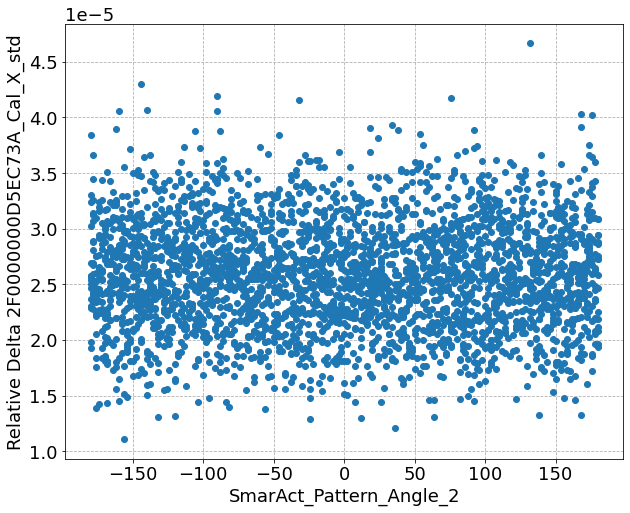

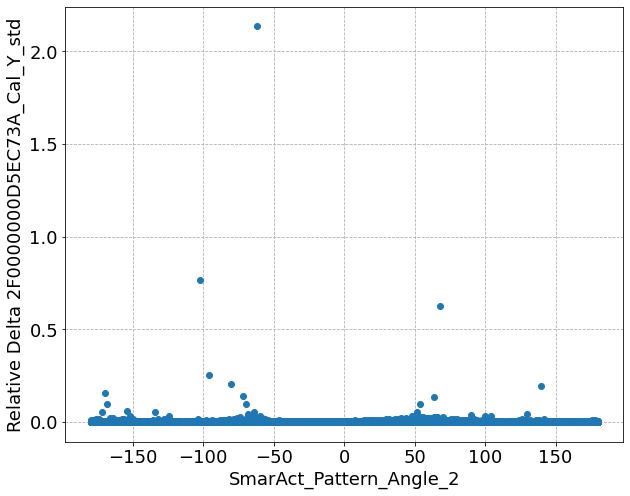

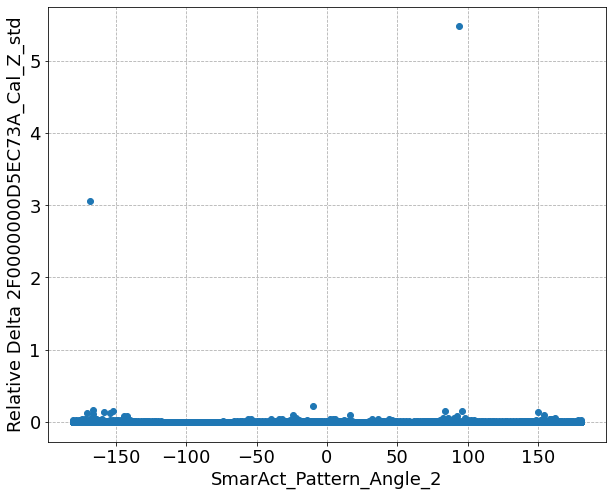

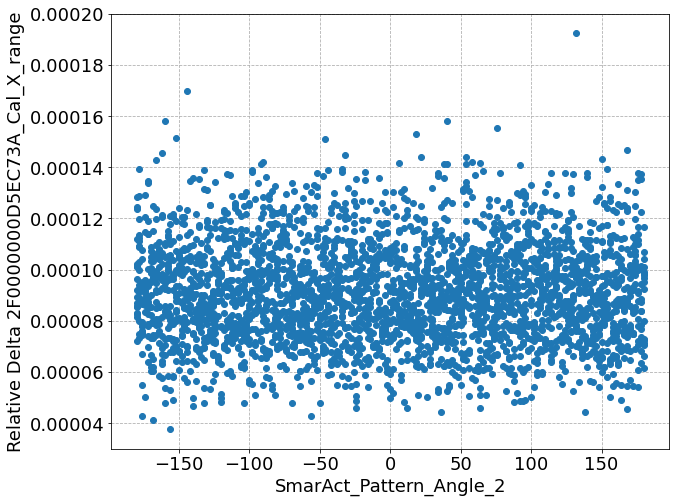

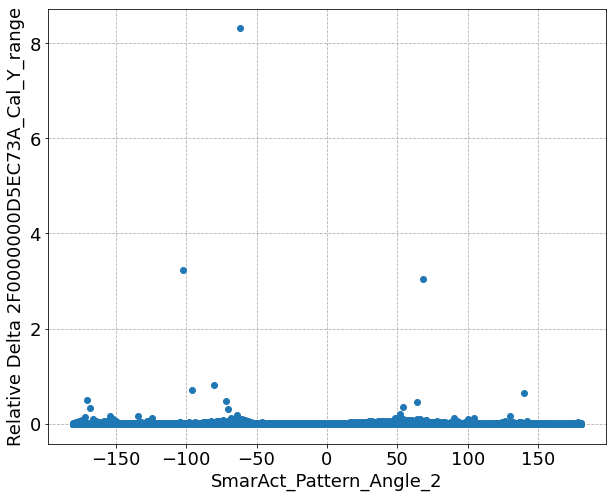

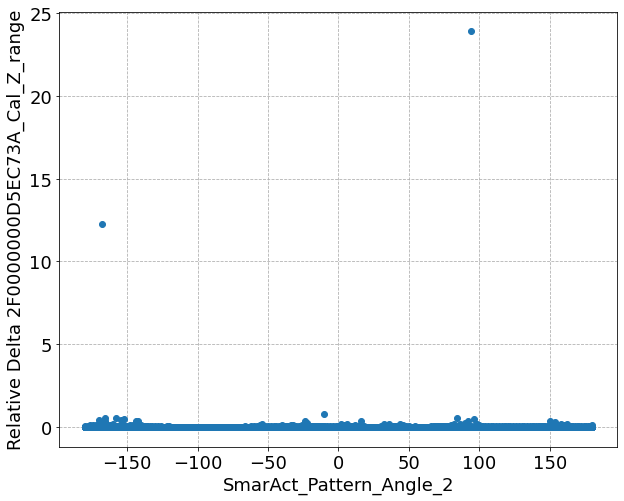

In [169]:
for A in ['1', '2']:
    for postfix in ['mean', 'std', 'range']:
        for i in ['X', 'Y', 'Z']:
            fig, ax = plt.subplots()
            ax.scatter(df_stat_cal[f'SmarAct_Pattern_Angle_{A}'], df_stat_cal[f'{probe}_Cal_{i}_{postfix}'])

            ax.set_xlabel(f'SmarAct_Pattern_Angle_{A}')
            ax.set_ylabel(f'Relative Delta {probe}_Cal_{i}_{postfix}')

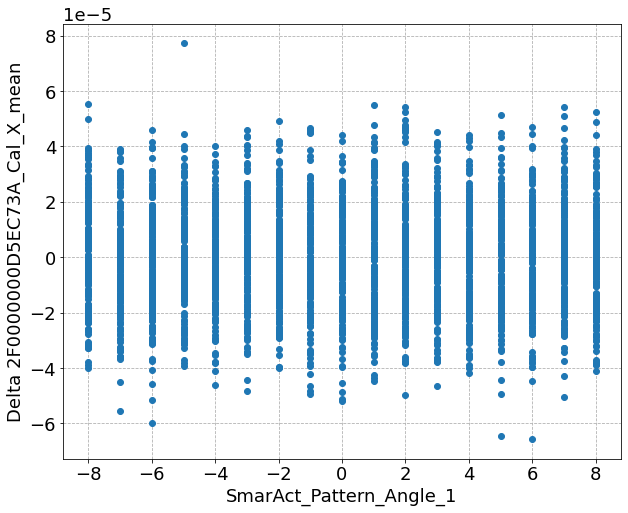

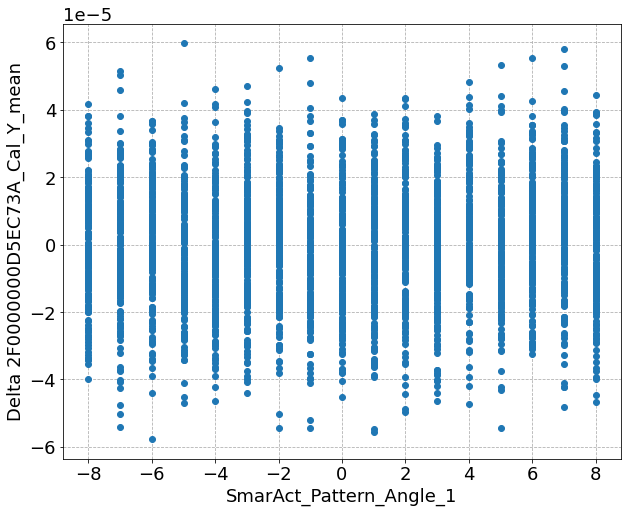

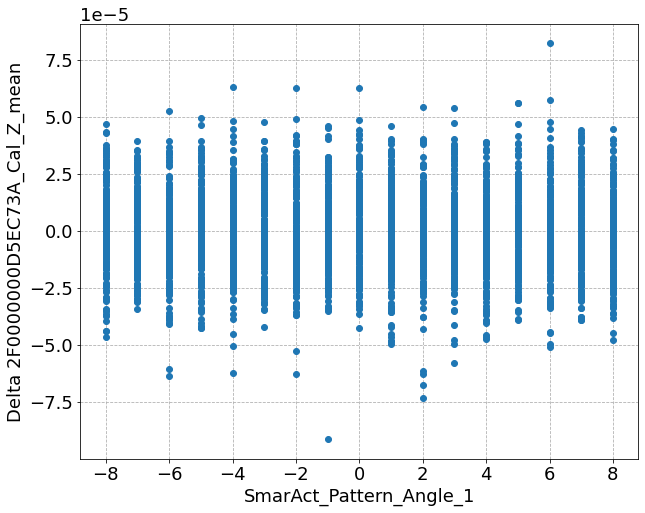

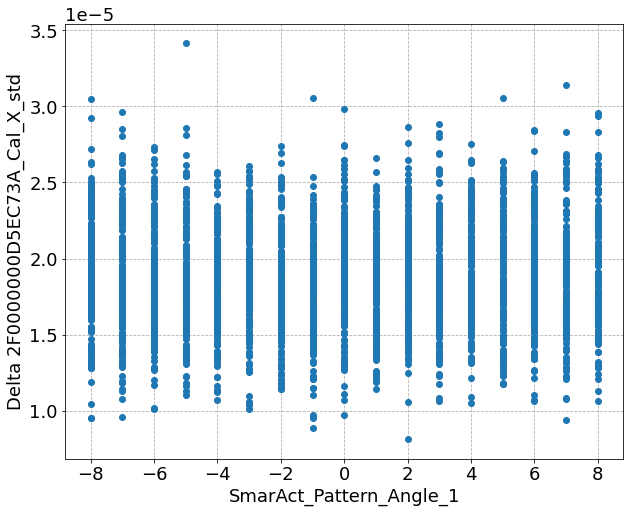

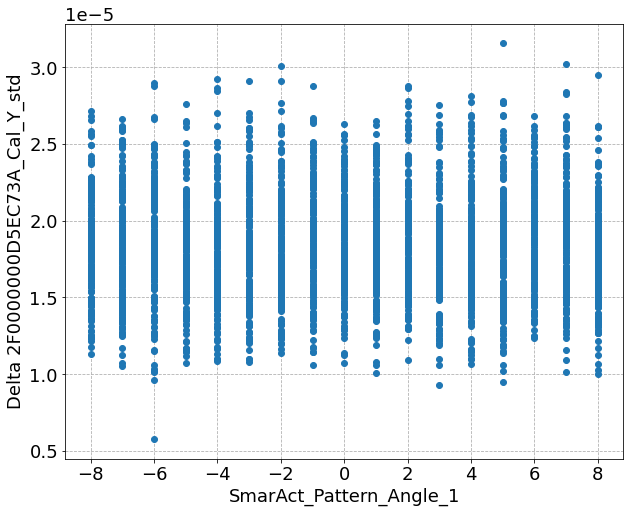

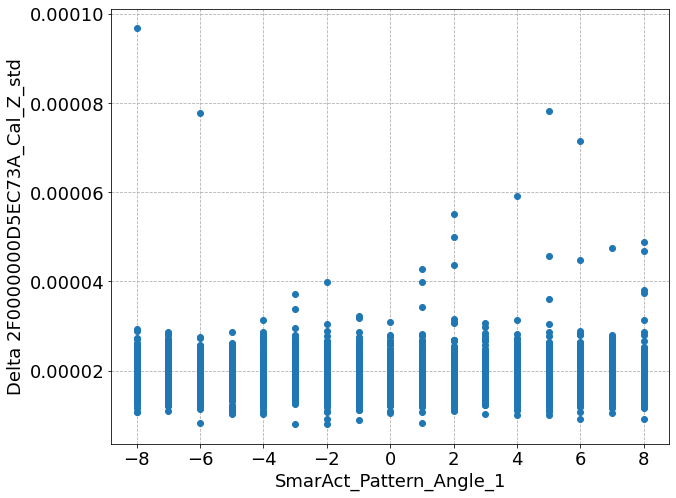

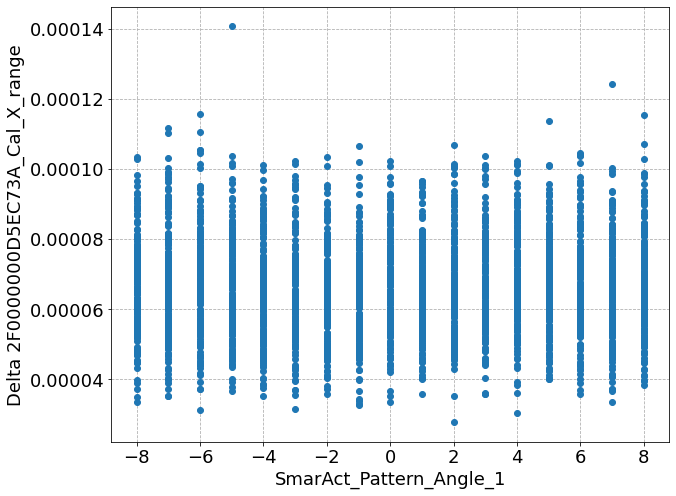

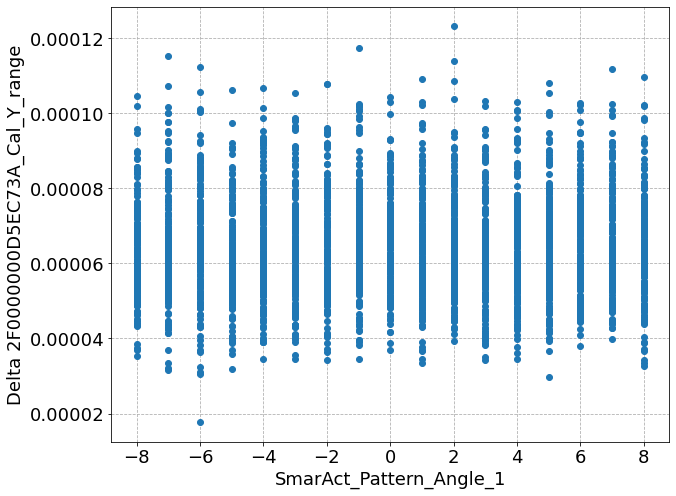

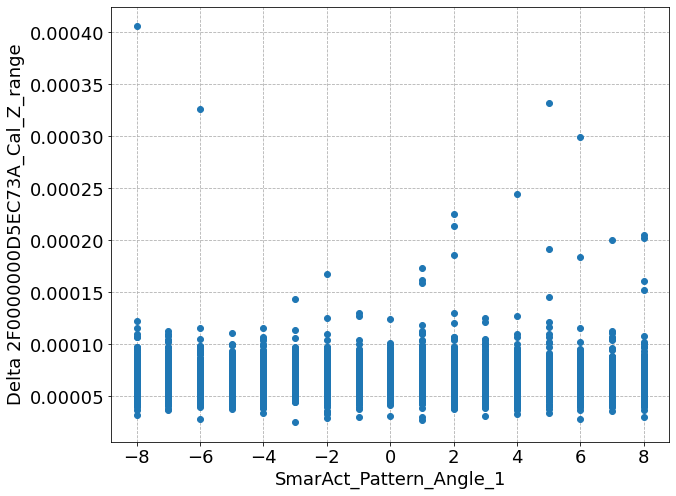

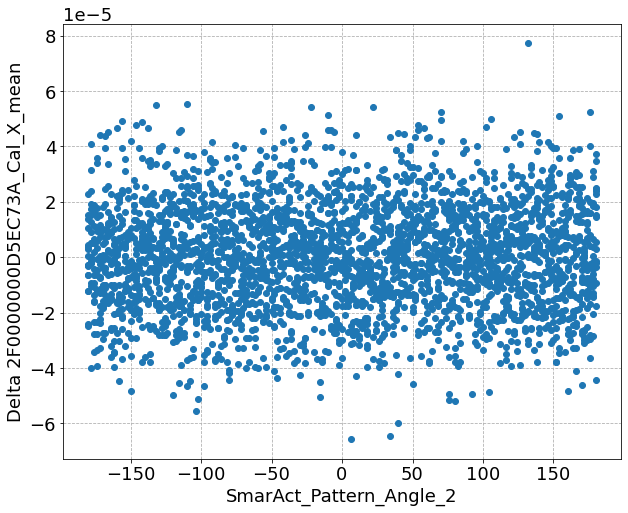

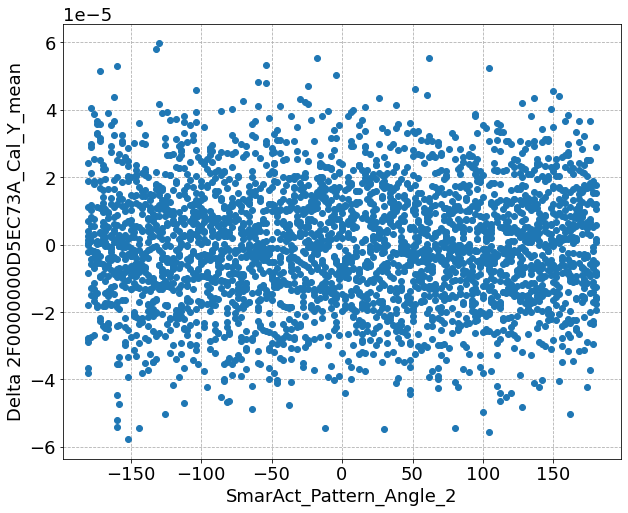

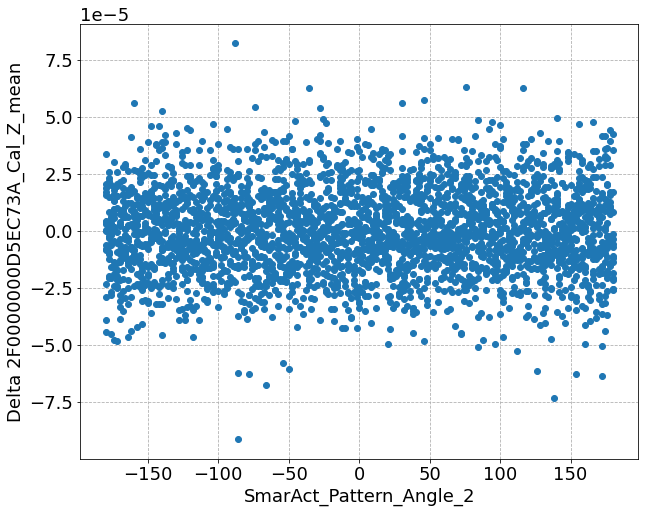

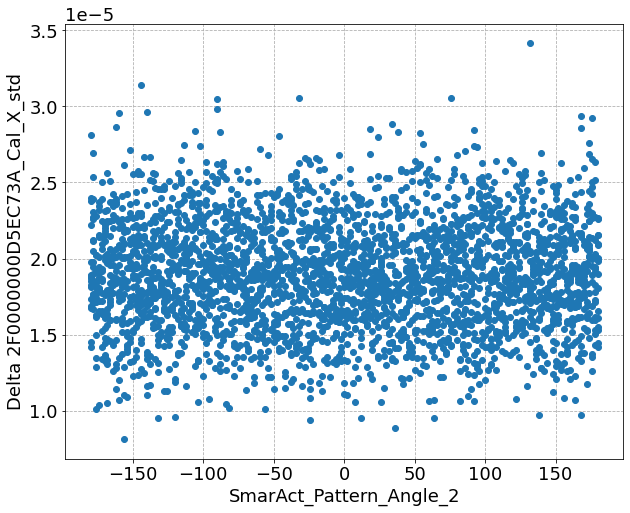

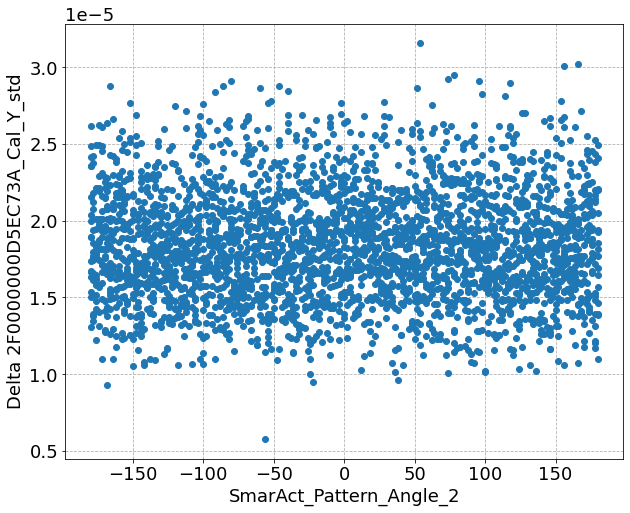

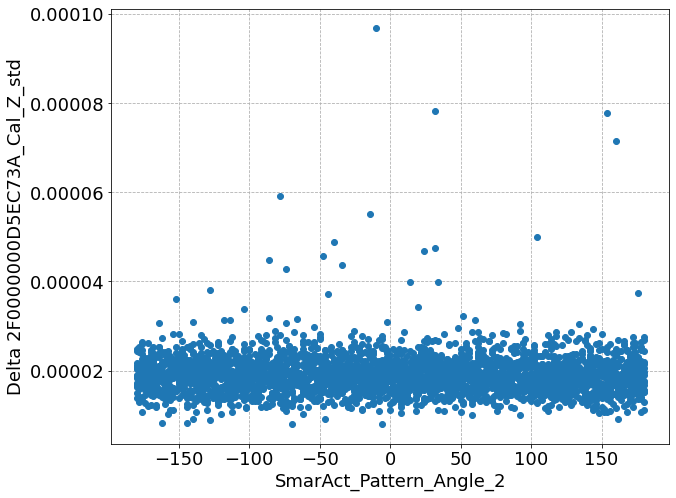

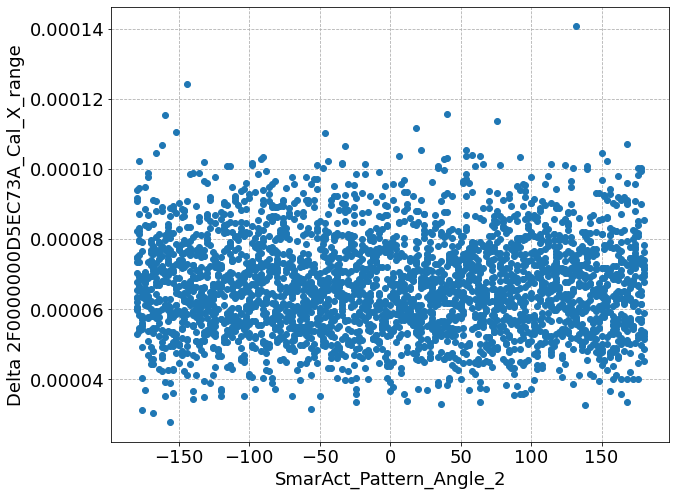

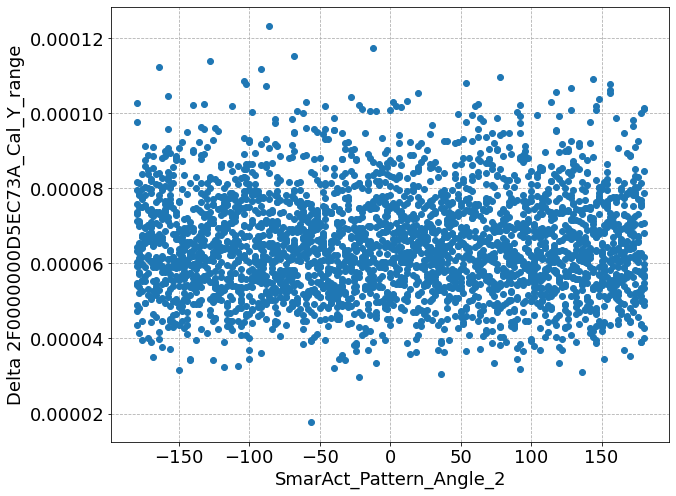

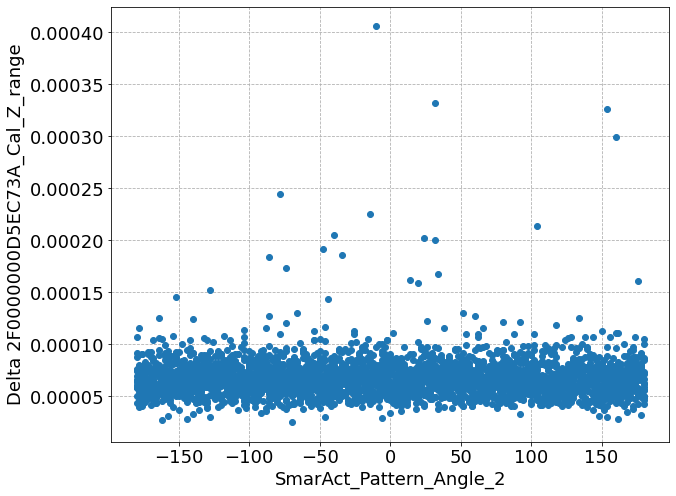

In [170]:
for A in ['1', '2']:
    for postfix in ['mean', 'std', 'range']:
        for i in ['X', 'Y', 'Z']:
            fig, ax = plt.subplots()
            ax.scatter(df_stat_cal_nonrel[f'SmarAct_Pattern_Angle_{A}'], df_stat_cal_nonrel[f'{probe}_Cal_{i}_{postfix}'])

            ax.set_xlabel(f'SmarAct_Pattern_Angle_{A}')
            ax.set_ylabel(f'Delta {probe}_Cal_{i}_{postfix}')

In [162]:
50 / 3e-5

1666666.6666666665

In [163]:
# Tesla per ADC, roughly
1/(50 / 3e-5)

6.000000000000001e-07

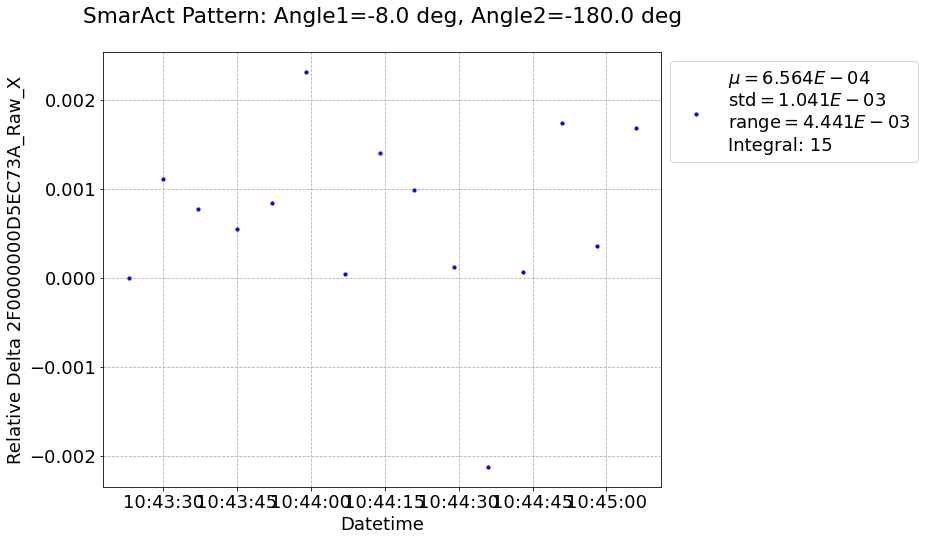

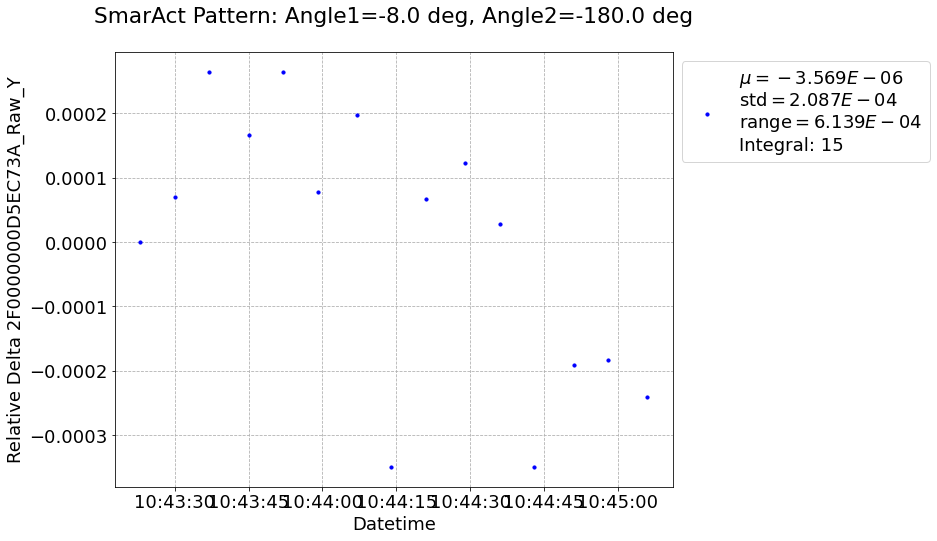

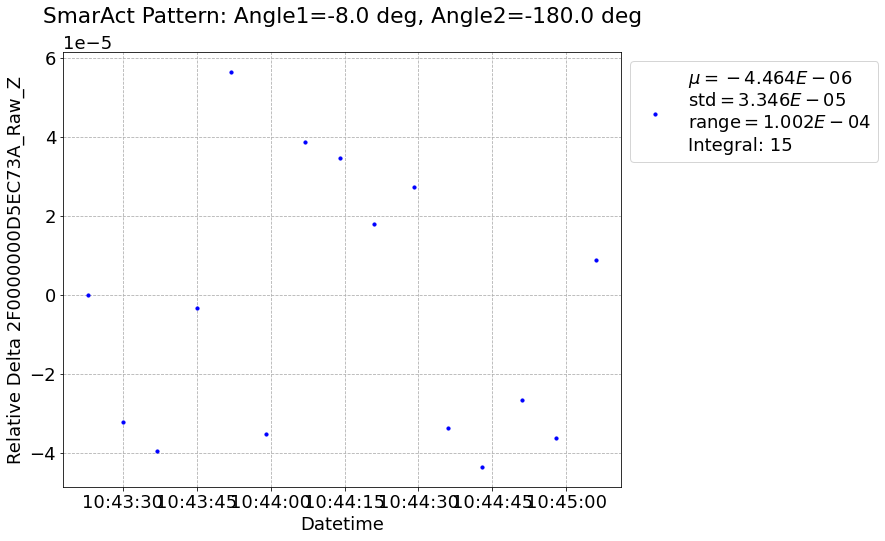

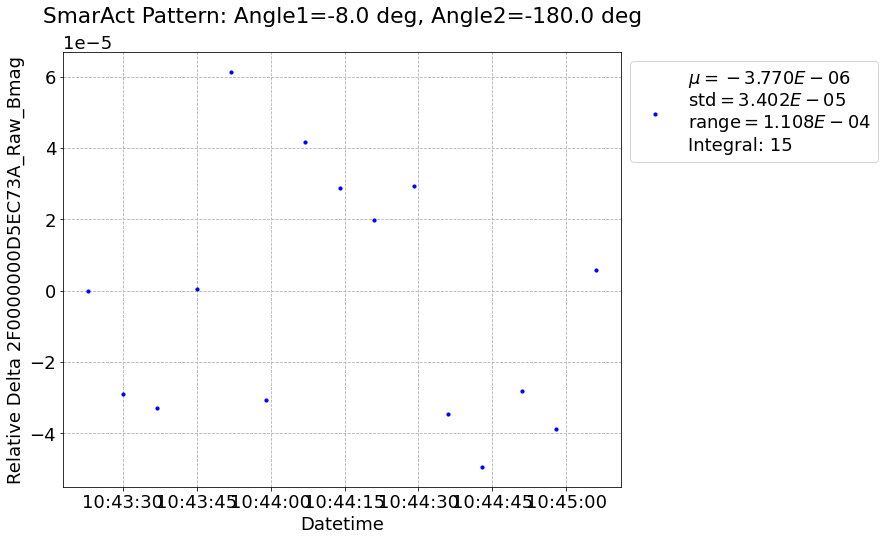

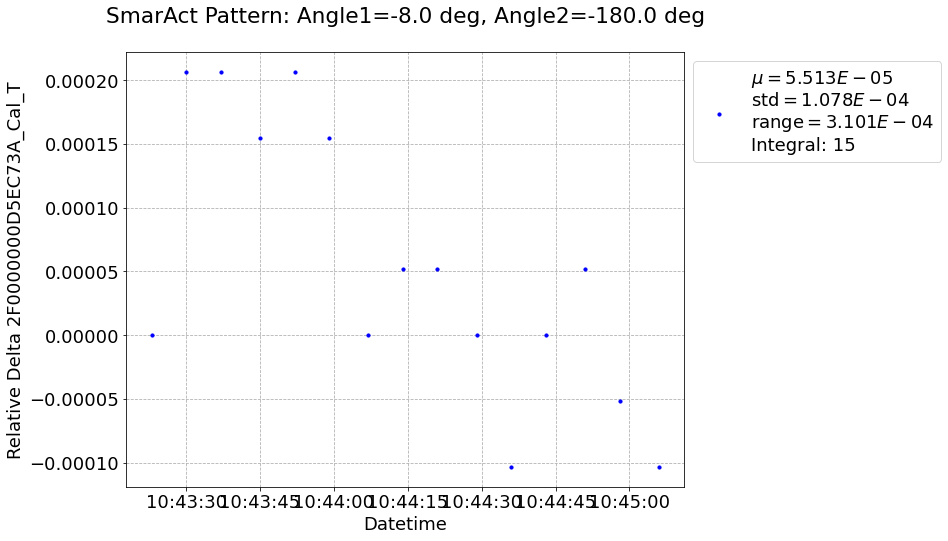

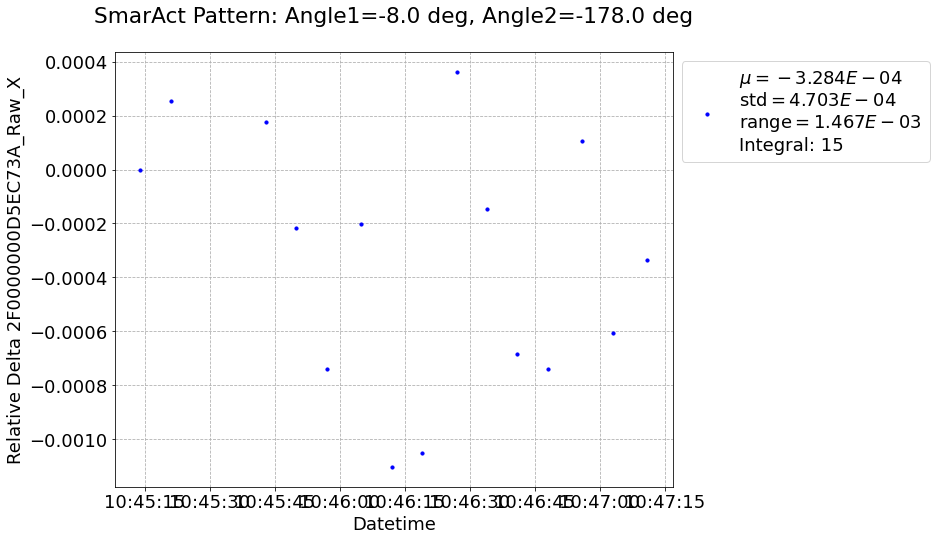

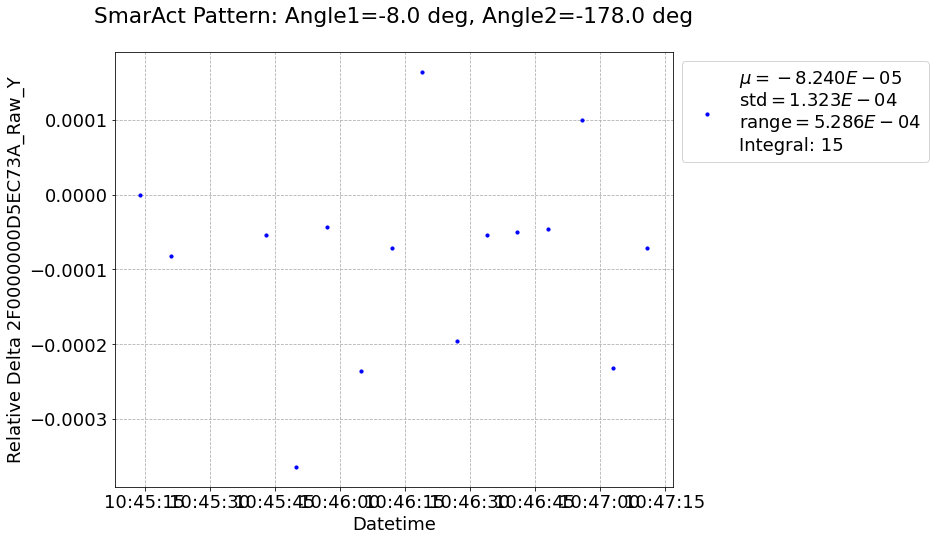

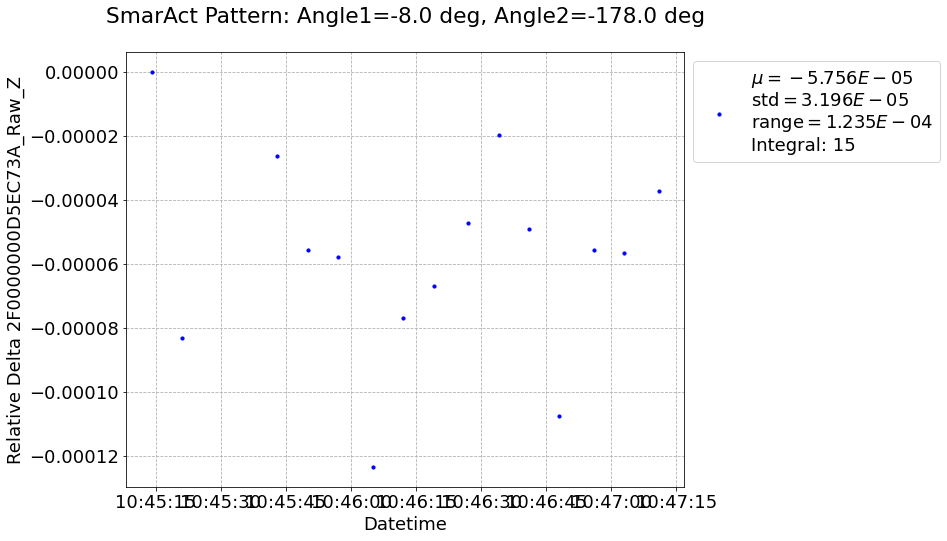

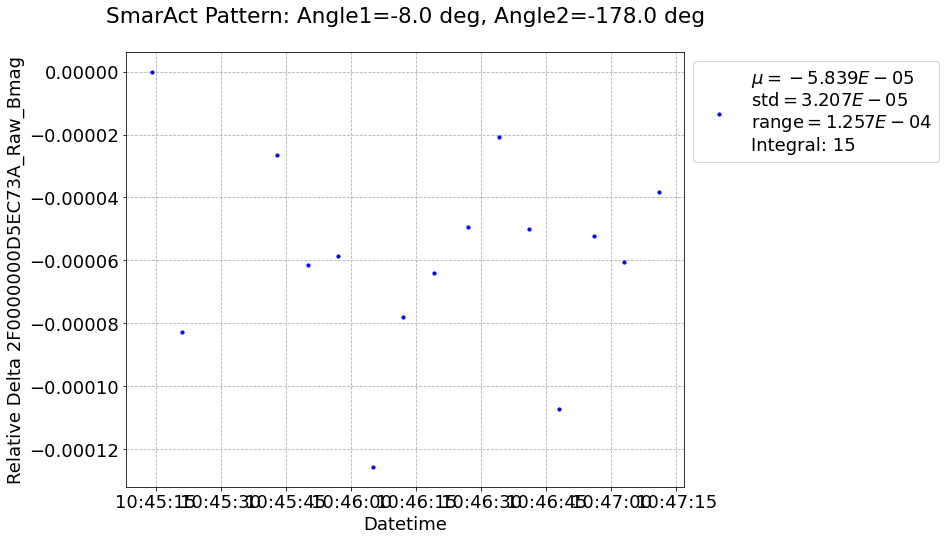

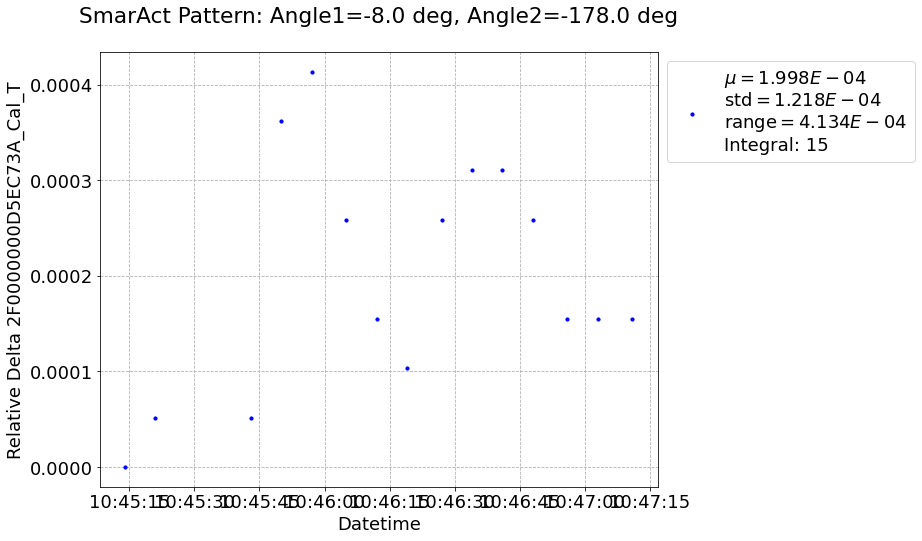

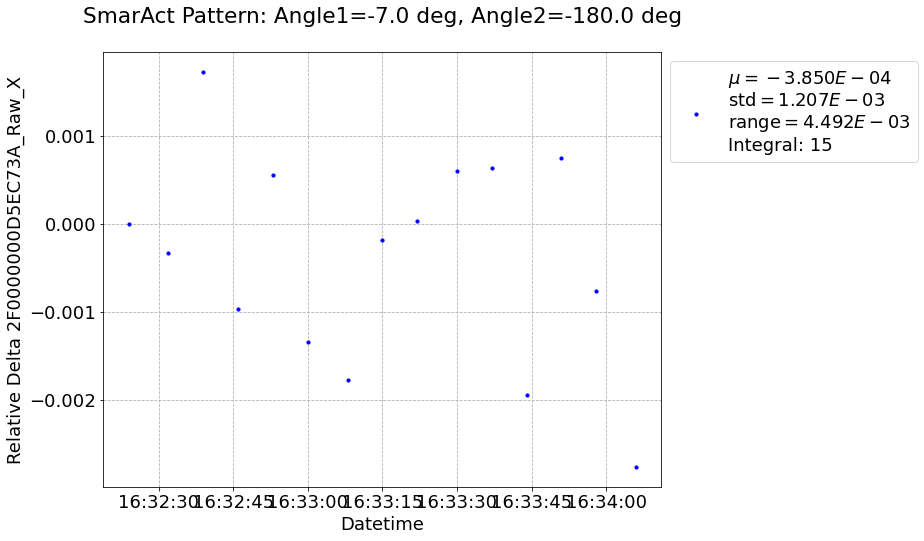

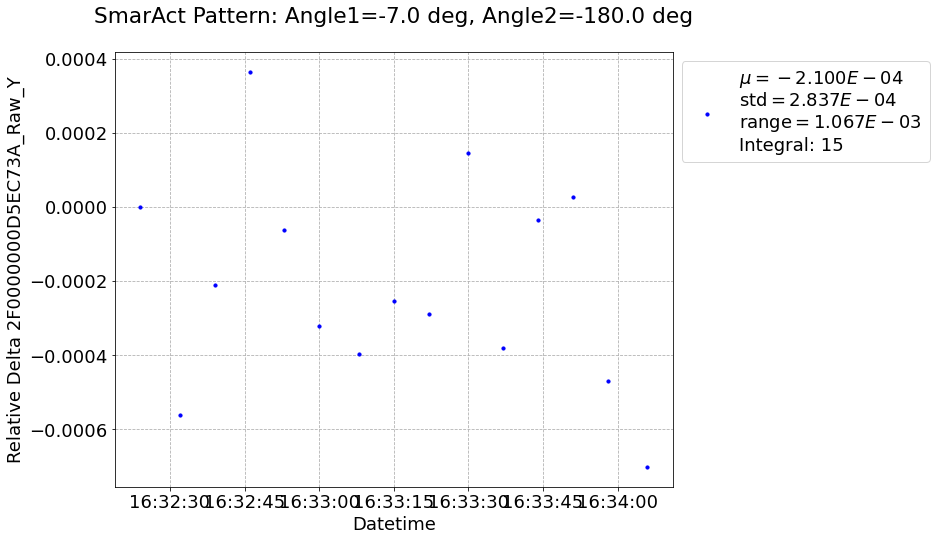

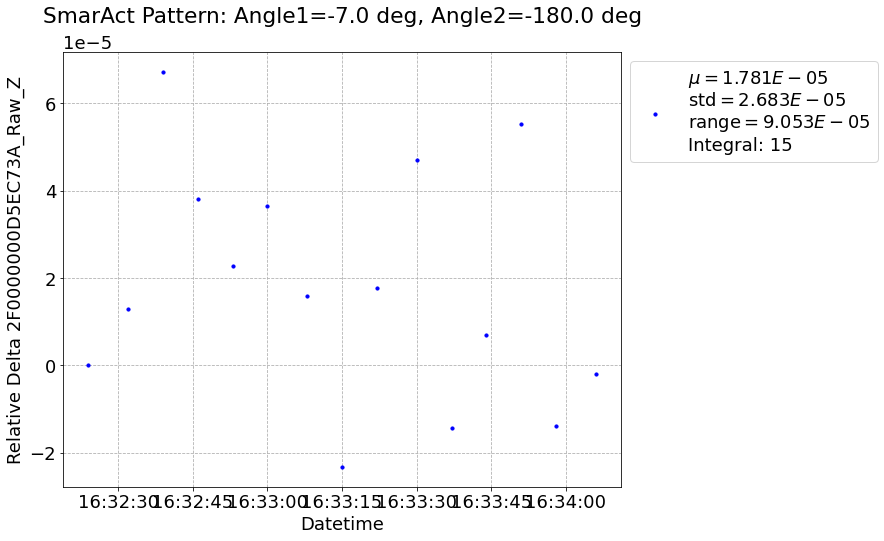

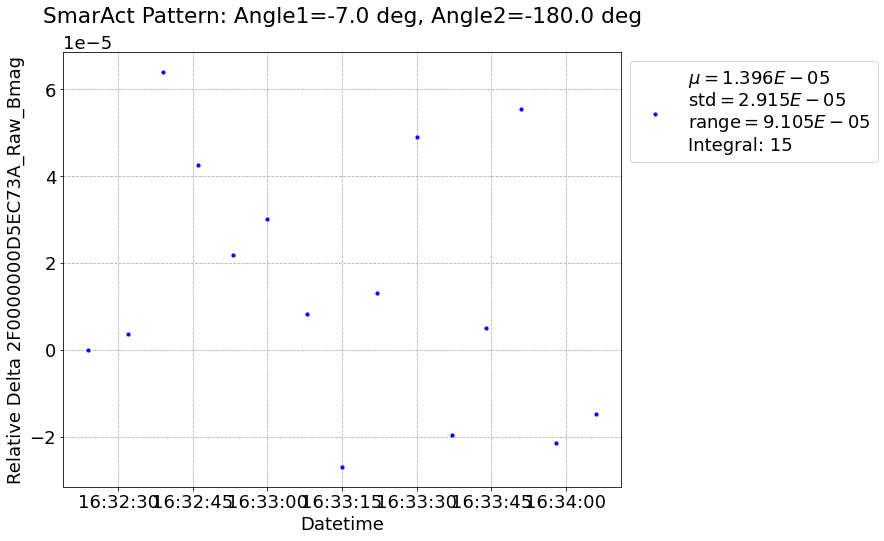

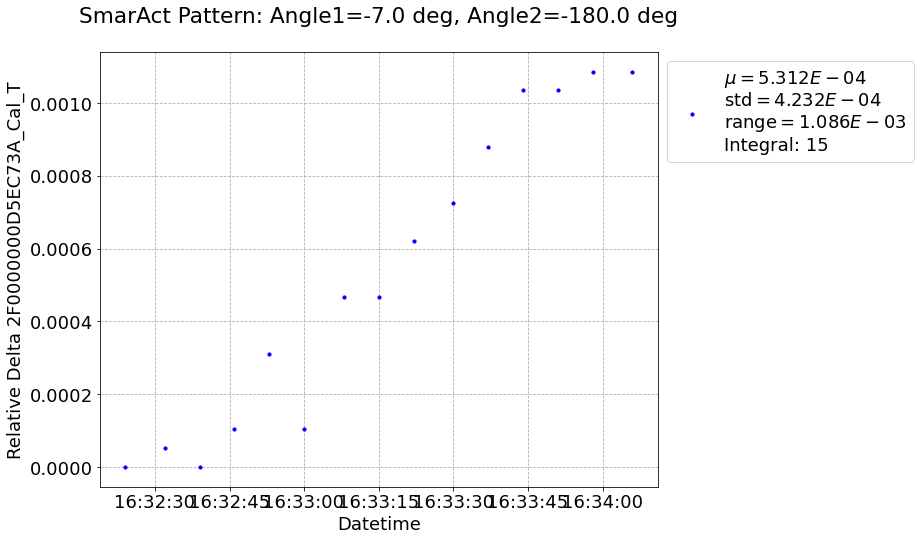

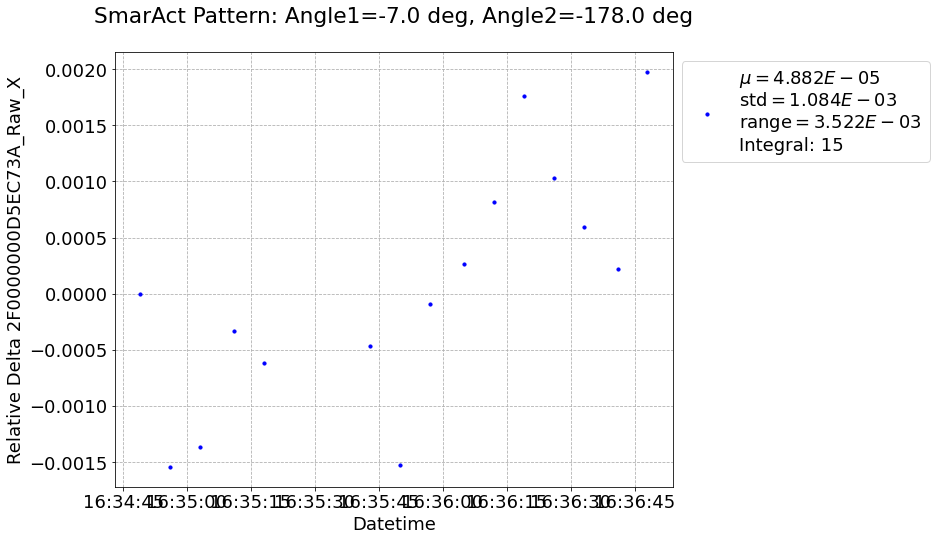

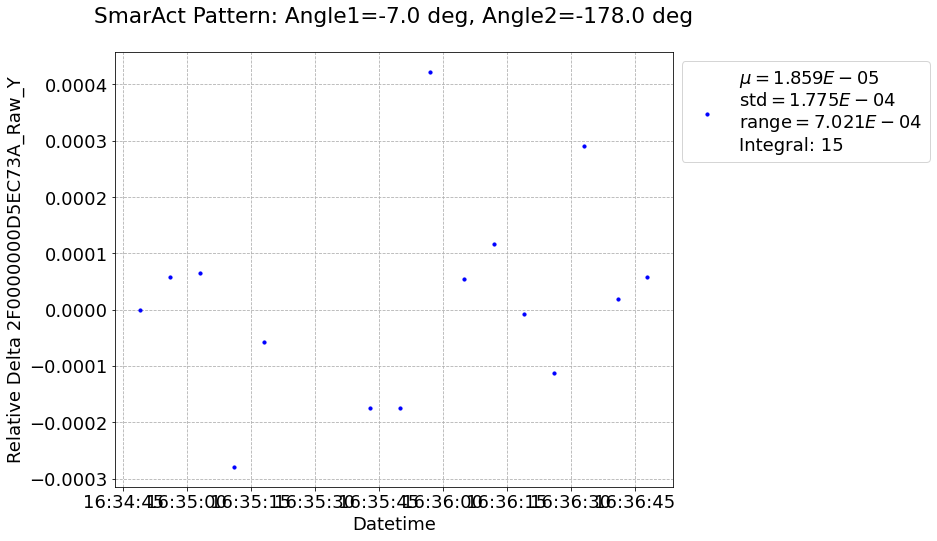

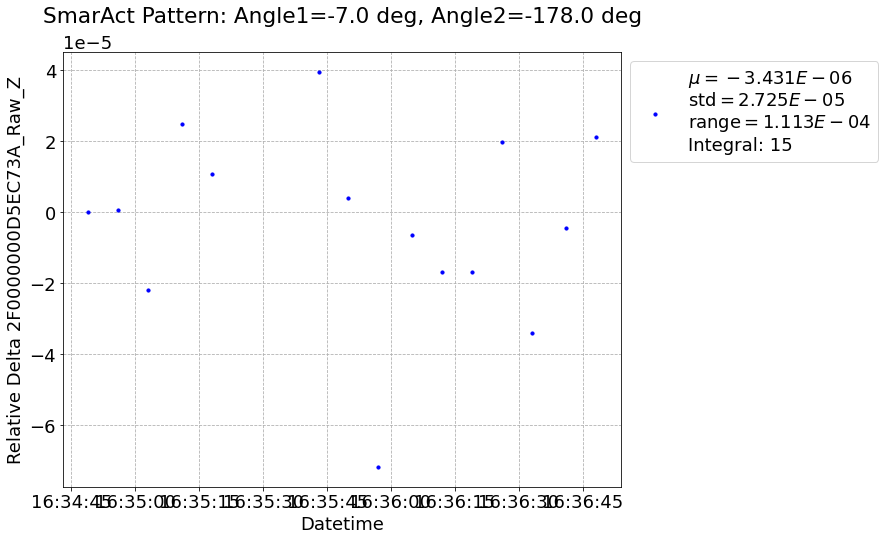

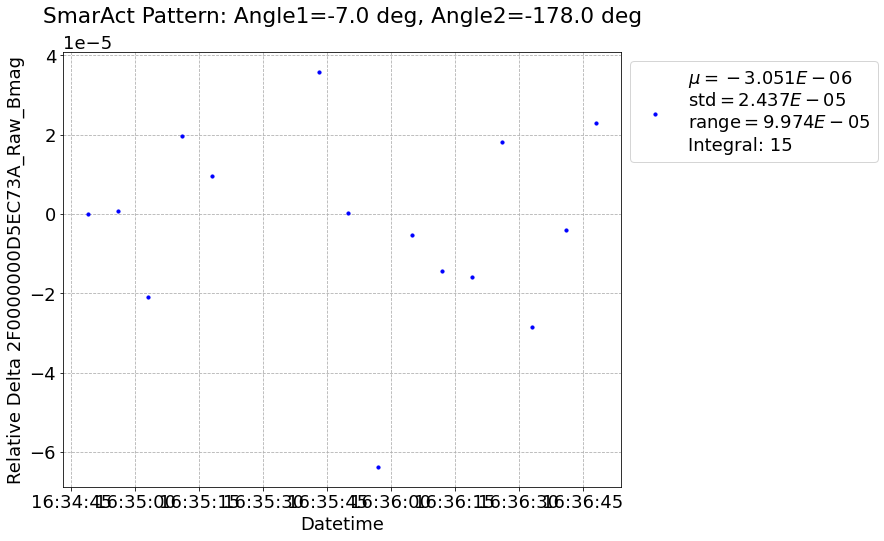

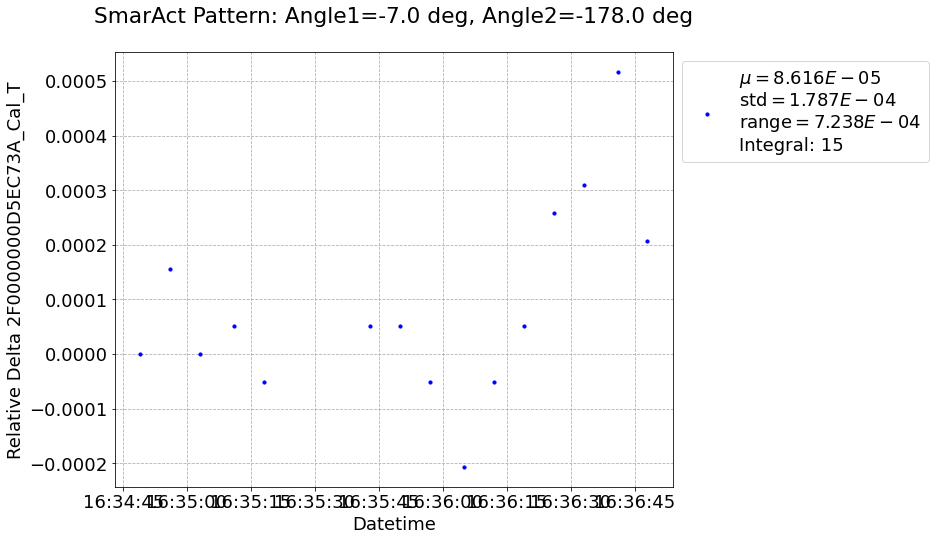

In [136]:
for SA1 in df.SmarAct_Pattern_Angle_1.unique()[:2]:
    for SA2 in df.SmarAct_Pattern_Angle_2.unique()[:2]:
        df_ = plot_components_pattern_point(df, SA1, SA2, components=['Raw_X', 'Raw_Y', 'Raw_Z', 'Raw_Bmag', 'Cal_T'], probe=probe, Delta=True, Relative=True)